<a href="https://colab.research.google.com/github/brainopensource/datascience-mvp/blob/ml-analytics-mvp/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics para conclusão da Sprint da Pós-Graduação em Ciência de Dados e Analytics (PUC Rio)

# Aluno Lucas da S. Rocha

## Introdução

Este notebook apresenta o desenvolvimento de um Mínimo Produto Viável (MVP) como parte do segundo módulo da Pós-Graduação em Ciência de Dados e Analytics da PUC-Rio. Utilizando dados abertos recentes sobre a produção de petróleo e gás no Brasil, disponibilizados pela Agência Nacional de Petróleo (ANP).

## Código do MVP

### Importação de Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import hashlib
import warnings
import missingno as msno
import re

### Configuração do Ambiente

Configurações estéticas do pandas para limitar o máximo de linhas, colunas e filtrar avisos.

In [3]:
# Definindo o limite de exibição colunas de dataframe para None (sem limite)
pd.set_option('display.max_columns', 48)

# Definindo o limite de exibição de linhas de dataframe para 48
pd.set_option('display.max_rows', 48)

# Filter warnings
warnings.filterwarnings('ignore')

### Variáveis Globais

In [4]:
# Data de referência da última produção presente no dado
data_referencia = pd.to_datetime('2024-06-01')

### Funções Auxiliares

In [5]:
# Criar uma função para calcular o tempo total de produção
def calcular_producao_por_campo(df):
    # Encontrar a data mínima de produção por campo
    min_dates = df.groupby('campo')['periodo'].min()

    # Calcular o tempo de produção para cada campo, baseado na data mínima
    tempo_producao = (data_referencia - min_dates).dt.days

    # Mapear a data mínima e tempo de produção de volta para o DataFrame original
    df['data_inicio'] = df['campo'].map(min_dates)
    df['tempo_total_producao_dias'] = df['campo'].map(tempo_producao)

    return df

### Criando dataset

Conforme sugerido, os dados foram disponibilizados publicamente no repositório do Github e lidos no formato Raw

[Link do Repositório](https://github.com/brainopensource/datascience-mvp)


In [6]:
url = "https://raw.githubusercontent.com/brainopensource/datascience-mvp/refs/heads/ml-analytics-mvp/datasets/monthly_production_concat/1980_2024_BR_production_data.parquet"
df_prod_base = pd.read_parquet(url)

In [7]:
# Drop the first column (index 0), which is the unnamed one
df_prod = df_prod_base.reset_index(drop=True).copy()

# Display the DataFrame to verify
display(df_prod)

estado   bacia   nome_poco_anp      campo    periodo  \
0       Rio de Janeiro  Campos   3-RJS-159-RJS      PAMPO 2011-01-01   
1       Rio de Janeiro  Campos    7-PM-17D-RJS      PAMPO 2011-01-01   
2       Rio de Janeiro  Campos  6-BRSA-806-RJS  CARATINGA 2011-01-01   
3       Rio de Janeiro  Campos  4-RJS-265A-RJS     TRILHA 2011-01-01   
4            São Paulo  Santos  1-BRSA-594-SPS   SAPINHOÁ 2011-01-01   
...                ...     ...             ...        ...        ...   
449635  Espírito Santo  Campos    7-OST-6H-ESS      OSTRA 2024-06-01   
449636  Espírito Santo  Campos    7-OST-7H-ESS      OSTRA 2024-06-01   
449637  Espírito Santo  Campos    7-OST-3H-ESS      OSTRA 2024-06-01   
449638  Espírito Santo  Campos    7-OST-1H-ESS      OSTRA 2024-06-01   
449639  Espírito Santo  Campos    7-OST-2H-ESS      OSTRA 2024-06-01   

         oleo_kbd  condensado_kbd  petroleo_kbd  gas_natural_mmscf_assoc  \
0        0.293000             0.0      0.293000                 0.287652   
1        0.196663             0.0      0.196663                 0.108893   
2       13.362645             0.0     13.362645                 7.112691   
3        0.241780             0.0      0.241780                 0.177410   
4       17.756235             0.0     17.756235                19.470869   
...           ...             ...           ...                      ...   
449635   0.000000             0.0      0.000000                 0.000000   
449636   0.000000             0.0      0.000000                 0.000000   
449637   2.115484             0.0      2.115484                 0.428597   
449638   1.685027             0.0      1.685027                 0.535491   
449639   0.615693             0.0      0.615693                 0.205330   

        gas_natural_mmscf_nassoc  gas_natural_mmscf_total   agua_kbd  \
0                            0.0                 0.287652   0.125568   
1                            0.0                 0.108893   0.012550   
2                            0.0                 7.112691   0.033568   
3                            0.0                 0.177410   0.004931   
4                            0.0                19.470869   0.000000   
...                          ...                      ...        ...   
449635                       0.0                 0.000000   0.000000   
449636                       0.0                 0.000000   0.000000   
449637                       0.0                 0.428597  12.502358   
449638                       0.0                 0.535491  14.169057   
449639                       0.0                 0.205330   3.587105   

        tempo_producao_hspormes   ano  mes  
0                             0  2011    1  
1                             0  2011    1  
2                             0  2011    1  
3                             0  2011    1  
4                             0  2011    1  
...                         ...   ...  ...  
449635                        0  2024    6  
449636                        0  2024    6  
449637                      554  2024    6  
449638                      556  2024    6  
449639                      220  2024    6  

[449640 rows x 15 columns]

### Transformações de dado

In [8]:
print(df_prod.dtypes)

estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dtype: object


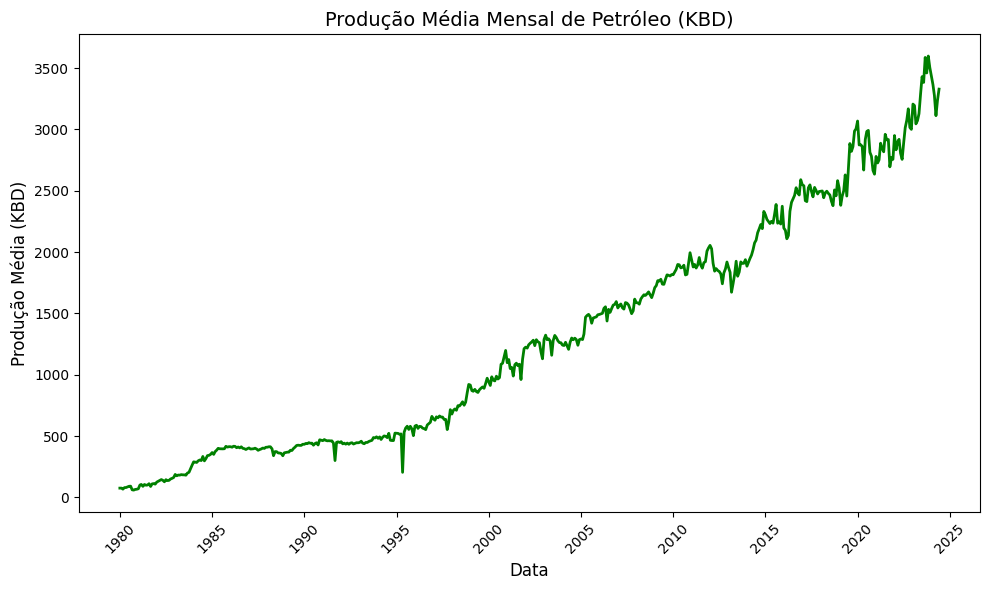

In [9]:
# Agrupar por ano e mês, somando a produção média diária em KBD (mil barris por dia)
df_grouped = df_prod.groupby(df_prod['periodo'].dt.to_period('M')).agg(producao_media_kbd=('petroleo_kbd', 'sum')).reset_index()

# Convertendo a coluna 'periodo' de volta para datetime (primeiro dia do mês) para fins de plotagem
df_grouped['periodo'] = df_grouped['periodo'].dt.to_timestamp()

# Plotar o gráfico da produção média em KBD ao longo dos meses
plt.figure(figsize=(10, 6))

# Plotando como linha com cor verde e sem marcadores grandes
plt.plot(df_grouped['periodo'], df_grouped['producao_media_kbd'], linestyle='-', color='green', linewidth=2)

# Alternativamente, para um gráfico de área
# plt.fill_between(df_grouped['periodo'], df_grouped['producao_media_kbd'], color='green', alpha=0.3)

# Adicionar títulos e labels
plt.title('Produção Média Mensal de Petróleo (KBD)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Produção Média (KBD)', fontsize=12)

# Exibir o gráfico com ajustes minimalistas
plt.grid(False)  # Remover grade para um visual mais limpo
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [10]:
# Agrupar por 'campo' e 'periodo', somando a produção total de cada campo por período
df_fields_prod = df_prod.groupby(['campo', 'periodo']).agg(
    oleo_kbd_total=('oleo_kbd', 'sum'),
    condensado_kbd_total=('condensado_kbd', 'sum'),
    petroleo_kbd_total=('petroleo_kbd', 'sum'),
    gas_natural_mmscf_assoc_total=('gas_natural_mmscf_assoc', 'sum'),
    gas_natural_mmscf_nassoc_total=('gas_natural_mmscf_nassoc', 'sum'),
    gas_natural_mmscf_total_total=('gas_natural_mmscf_total', 'sum'),
    agua_kbd_total=('agua_kbd', 'sum'),
    tempo_producao_hspormes_total=('tempo_producao_hspormes', 'sum')
).reset_index()

# Exibir o DataFrame auxiliar
display(df_fields_prod)

campo    periodo  oleo_kbd_total  condensado_kbd_total  \
0              ABALONE 2009-07-01        1.019355                   0.0   
1              ABALONE 2009-08-01        0.670778                   0.0   
2              ABALONE 2009-09-01        1.840570                   0.0   
3              ABALONE 2009-10-01        2.293708                   0.0   
4              ABALONE 2009-11-01        0.889189                   0.0   
...                ...        ...             ...                   ...   
32153  ÁREA DO RJS-150 1984-12-01        1.322889                   0.0   
32154  ÁREA DO RJS-150 1985-01-01        1.046949                   0.0   
32155  ÁREA DO RJS-150 1985-02-01        1.006370                   0.0   
32156  ÁREA DO RJS-150 1985-03-01        0.799415                   0.0   
32157  ÁREA DO RJS-150 1985-04-01        0.000000                   0.0   

       petroleo_kbd_total  gas_natural_mmscf_assoc_total  \
0                1.019355                       3.605638   
1                0.670778                       2.061891   
2                1.840570                       6.556940   
3                2.293708                       9.579469   
4                0.889189                       4.608042   
...                   ...                            ...   
32153            1.322889                       2.960739   
32154            1.046949                       3.471092   
32155            1.006370                       2.705357   
32156            0.799415                       1.405751   
32157            0.000000                       0.000000   

       gas_natural_mmscf_nassoc_total  gas_natural_mmscf_total_total  \
0                                 0.0                       3.605638   
1                                 0.0                       2.061891   
2                                 0.0                       6.556940   
3                                 0.0                       9.579469   
4                                 0.0                       4.608042   
...                               ...                            ...   
32153                             0.0                       2.960739   
32154                             0.0                       3.471092   
32155                             0.0                       2.705357   
32156                             0.0                       1.405751   
32157                             0.0                       0.000000   

       agua_kbd_total  tempo_producao_hspormes_total  
0            0.000000                            292  
1            0.000000                            178  
2            0.000000                            462  
3            0.000000                            653  
4            0.000000                            316  
...               ...                            ...  
32153        0.946150                              0  
32154        0.930608                              0  
32155        0.681097                              0  
32156        0.691067                              0  
32157        0.000000                              0  

[32158 rows x 10 columns]

In [11]:
# Listar todos os campos presentes no df_fields_prod
campos = df_fields_prod['campo'].unique()
print("Campos presentes no DataFrame:")
print(campos)

Campos presentes no DataFrame:
['ABALONE' 'AGULHA' 'ALBACORA' 'ALBACORA LESTE' 'ANEQUIM' 'ARABAIANA'
 'ARATUM' 'AREA DO RNS-36' 'AREA DO SES-2' 'AREA do BAS-37 (Licitado)'
 'ARGONAUTA' 'ATAPU' 'ATAPU_ECO' 'ATLANTA' 'ATUM' 'AnC_BRAVA' 'AnC_Forno'
 'AnC_MERO' 'AnC_NORTE_ATAPU' 'AnC_TARTARUGA VERDE' 'AnC_TUPI' 'BADEJO'
 'BAGRE' 'BALEIA ANÃ' 'BALEIA AZUL' 'BALEIA FRANCA' 'BARRACUDA' 'BAÚNA'
 'BERBIGÃO' 'BICUDO' 'BIJUPIRÁ' 'BIQUARA' 'BONITO' 'BÚZIOS' 'BÚZIOS_ECO'
 'CACHALOTE' 'CAIOBA' 'CAMARUPIM' 'CAMARUPIM NORTE' 'CAMORIM' 'CANAPU'
 'CANDEIAS' 'CANGOÁ' 'CARAPEBA' 'CARATINGA' 'CARAVELA' 'CARAÚNA' 'CAVALA'
 'CAVALO-MARINHO' 'CAÇÃO' 'CHERNE' 'CIOBA' 'CONGRO' 'CORAL' 'CORVINA'
 'CURIMÃ' 'DENTÃO' 'DOM JOÃO' 'DOM JOÃO MAR' 'DOURADO' 'ENCHOVA'
 'ENCHOVA OESTE' 'ESPADA' 'ESPADARTE' 'ESPADIM' 'ESTRELA DO MAR' 'FRADE'
 'GAROUPA' 'GAROUPINHA' 'GOLFINHO' 'GUARICEMA' 'ITAPARICA' 'ITAPU'
 'ITAPU_ECO' 'JUBARTE' 'LAGOSTA' 'LAPA' 'LINGUADO' 'MACAU' 'MALHADO'
 'MANATI' 'MARIMBÁ' 'MARLIM' 'MARLIM LESTE' 'MAR

In [12]:
# Calcular a produção acumulada por campo e período
df_fields_prod['producao_acumulada'] = df_fields_prod.groupby('campo')['petroleo_kbd_total'].cumsum()

# Filtrar os dados para considerar apenas o período até 2024-06-01
df_filtered = df_fields_prod[df_fields_prod['periodo'] >= '2024-06-01']

In [13]:
# Ordenar o DataFrame por produção acumulada
df_filtered_sorted = df_filtered.sort_values(by='producao_acumulada', ascending=False)

# Exibir o DataFrame ordenado (apenas para o período até 2024-06-01)
display(df_filtered_sorted[['campo', 'periodo', 'producao_acumulada']].head(20))

campo    periodo  producao_acumulada
29808             TUPI 2024-06-01        92739.650919
19975           MARLIM 2024-06-01        86901.363189
26521         RONCADOR 2024-06-01        51510.188377
20554       MARLIM SUL 2024-06-01        47920.826456
1130          ALBACORA 2024-06-01        30714.644773
17660          JUBARTE 2024-06-01        29016.340379
27276         SAPINHOÁ 2024-06-01        25053.209140
5070         BARRACUDA 2024-06-01        21617.015366
6798            BÚZIOS 2024-06-01        19525.472868
6832        BÚZIOS_ECO 2024-06-01        15129.104502
1394    ALBACORA LESTE 2024-06-01        13818.808440
19575          MARIMBÁ 2024-06-01        13550.955934
23208            PAMPO 2024-06-01        11597.396721
9751         CARATINGA 2024-06-01        10571.040580
9455          CARAPEBA 2024-06-01         8887.824134
24716        PEREGRINO 2024-06-01         8773.190383
15190        ESPADARTE 2024-06-01         6258.999223
20985             MERO 2024-06-01         6196.466578
28591  TARTARUGA VERDE 2024-06-01         5739.778088
30904         VERMELHO 2024-06-01         5699.155969

In [14]:
# Aplicar a função ao DataFrame
df_fields_prod = calcular_producao_por_campo(df_fields_prod)

# Exibir as primeiras linhas para verificar as novas colunas
display(df_fields_prod[['campo', 'periodo', 'data_inicio', 'tempo_total_producao_dias']])

campo    periodo data_inicio  tempo_total_producao_dias
0              ABALONE 2009-07-01  2009-07-01                       5449
1              ABALONE 2009-08-01  2009-07-01                       5449
2              ABALONE 2009-09-01  2009-07-01                       5449
3              ABALONE 2009-10-01  2009-07-01                       5449
4              ABALONE 2009-11-01  2009-07-01                       5449
...                ...        ...         ...                        ...
32153  ÁREA DO RJS-150 1984-12-01  1984-08-01                      14549
32154  ÁREA DO RJS-150 1985-01-01  1984-08-01                      14549
32155  ÁREA DO RJS-150 1985-02-01  1984-08-01                      14549
32156  ÁREA DO RJS-150 1985-03-01  1984-08-01                      14549
32157  ÁREA DO RJS-150 1985-04-01  1984-08-01                      14549

[32158 rows x 4 columns]

In [15]:
# Filtrar os dados para considerar apenas o período até 2024-06-01
#df_filtered = df_fields_prod[df_fields_prod['periodo'] <= '2024-06-01']

# Obter a data de início de produção (data mínima) e a produção acumulada até 2024-06-01 por campo
df_spuds = df_filtered.groupby('campo').agg(
    data_inicio=('periodo', 'min'),  # Data mínima (data de início)
    producao_acumulada_em_2024_06_01=('producao_acumulada', 'last')  # Produção acumulada até 2024-06-01
).reset_index()

In [16]:
display(df_spuds.head(40))

campo data_inicio  producao_acumulada_em_2024_06_01
0                ABALONE  2024-06-01                         23.009608
1               ALBACORA  2024-06-01                      30714.644773
2         ALBACORA LESTE  2024-06-01                      13818.808440
3              ARABAIANA  2024-06-01                         73.013925
4              ARGONAUTA  2024-06-01                       3725.471846
5                  ATAPU  2024-06-01                       3089.892224
6              ATAPU_ECO  2024-06-01                       1893.040069
7                ATLANTA  2024-06-01                        964.778572
8               AnC_MERO  2024-06-01                        176.921914
9        AnC_NORTE_ATAPU  2024-06-01                         56.632217
10              AnC_TUPI  2024-06-01                        246.764203
11             BARRACUDA  2024-06-01                      21617.015366
12                 BAÚNA  2024-06-01                       5030.418565
13              BERBIGÃO  2024-06-01                       3086.860512
14                BONITO  2024-06-01                       4309.310577
15                BÚZIOS  2024-06-01                      19525.472868
16            BÚZIOS_ECO  2024-06-01                      15129.104502
17              CANDEIAS  2024-06-01                        195.991618
18                CANGOÁ  2024-06-01                          8.312167
19              CARAPEBA  2024-06-01                       8887.824134
20             CARATINGA  2024-06-01                      10571.040580
21              DOM JOÃO  2024-06-01                         12.937947
22               ENCHOVA  2024-06-01                       5325.136774
23         ENCHOVA OESTE  2024-06-01                       1333.072661
24             ESPADARTE  2024-06-01                       6258.999223
25               ESPADIM  2024-06-01                          2.631303
26                 FRADE  2024-06-01                       4841.088783
27              GOLFINHO  2024-06-01                       5234.382794
28                 ITAPU  2024-06-01                       1310.587513
29             ITAPU_ECO  2024-06-01                        975.292693
30               JUBARTE  2024-06-01                      29016.340379
31                  LAPA  2024-06-01                       3709.838000
32              LINGUADO  2024-06-01                       4945.405483
33                 MACAU  2024-06-01                        109.055184
34               MARIMBÁ  2024-06-01                      13550.955934
35                MARLIM  2024-06-01                      86901.363189
36            MARLIM SUL  2024-06-01                      47920.826456
37                  MERO  2024-06-01                       6196.466578
38              MEXILHÃO  2024-06-01                        636.852260
39  NORDESTE DE SAPINHOÁ  2024-06-01                         36.688853

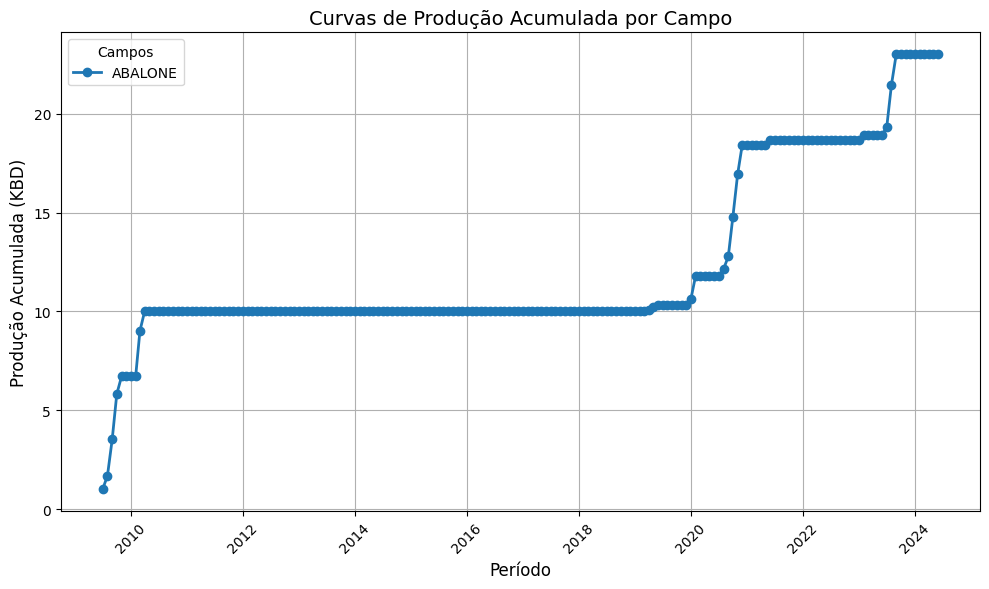

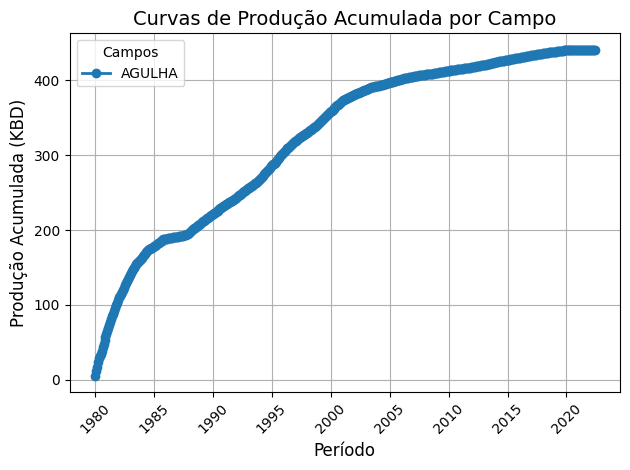

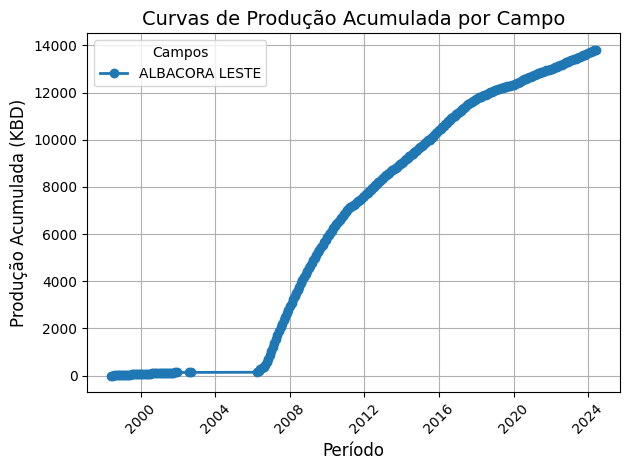

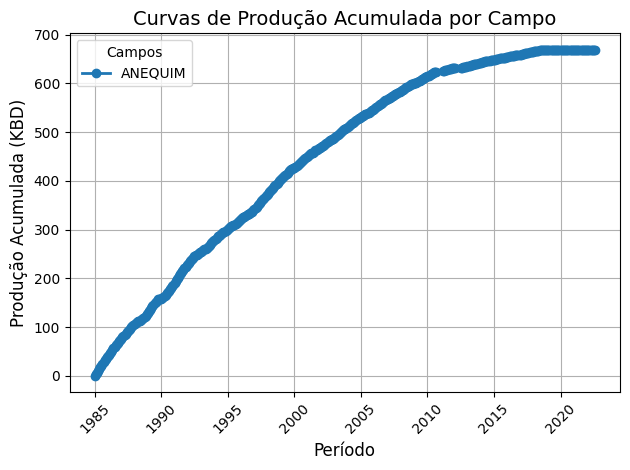

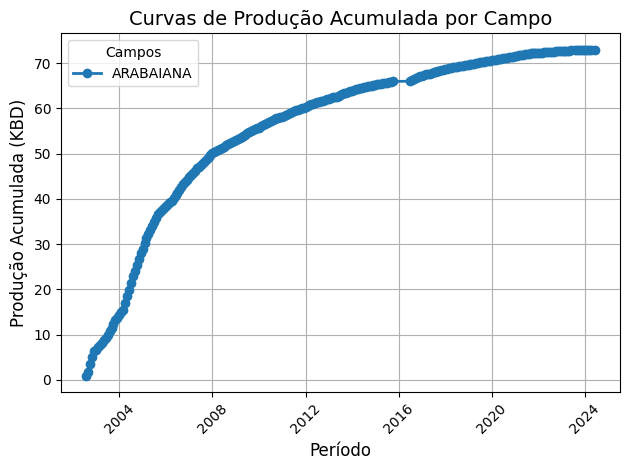

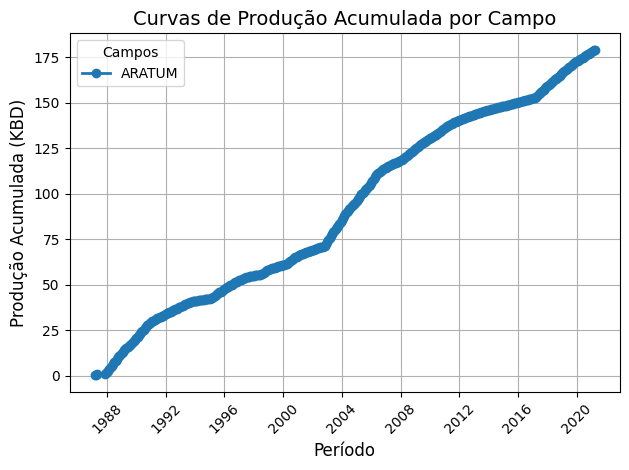

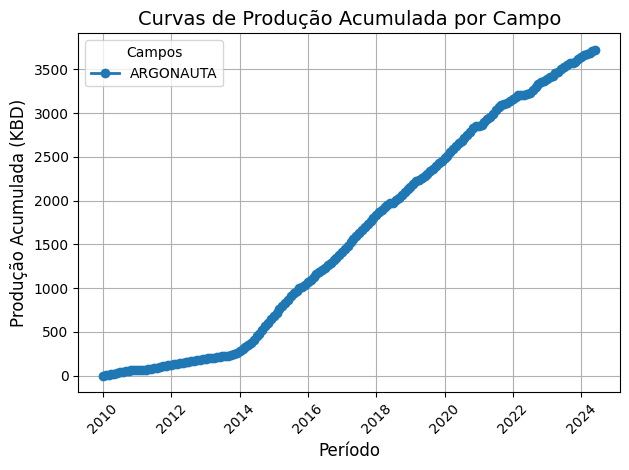

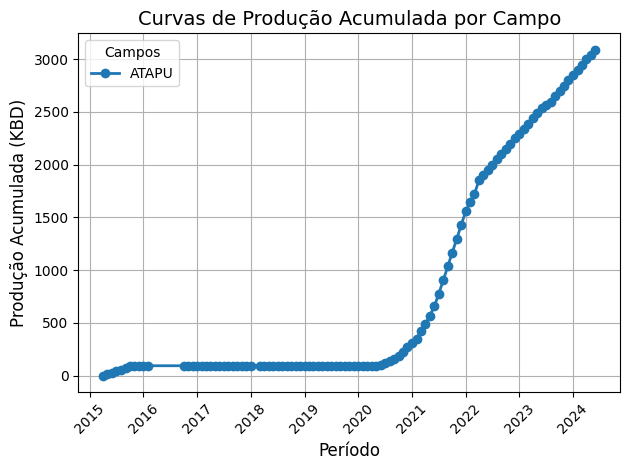

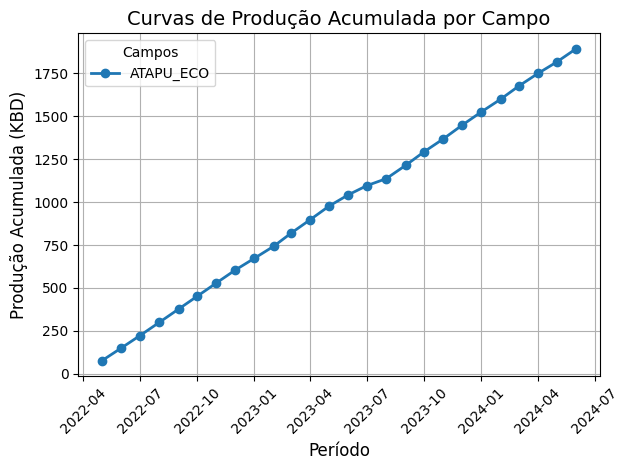

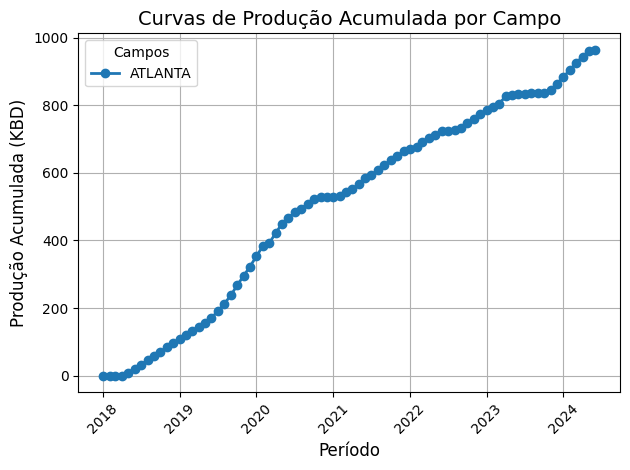

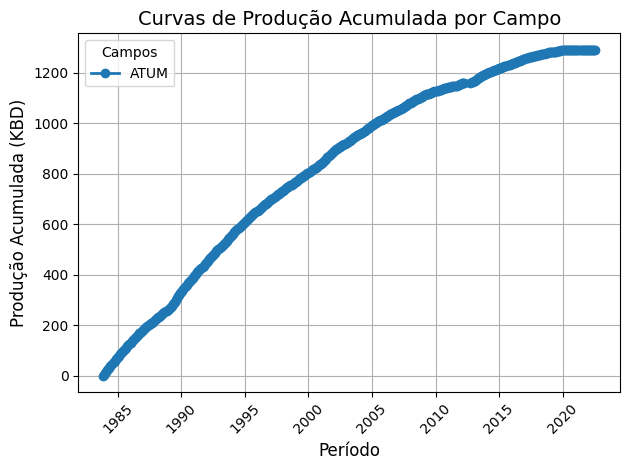

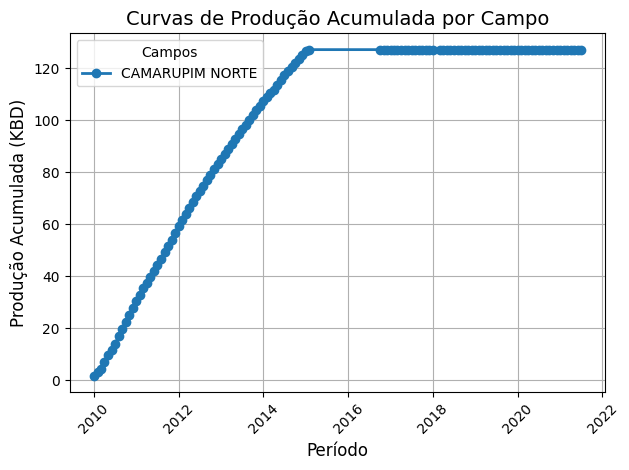

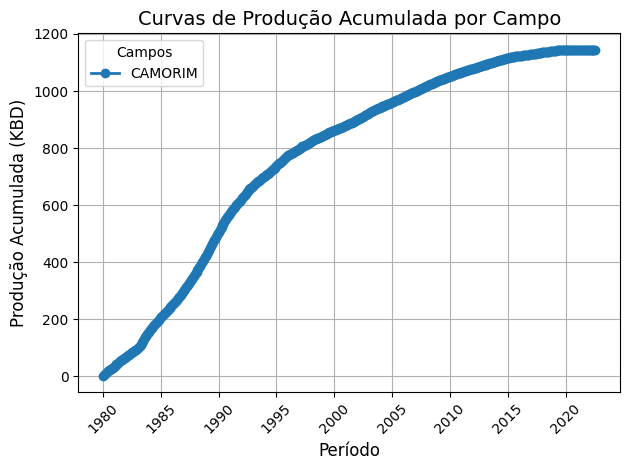

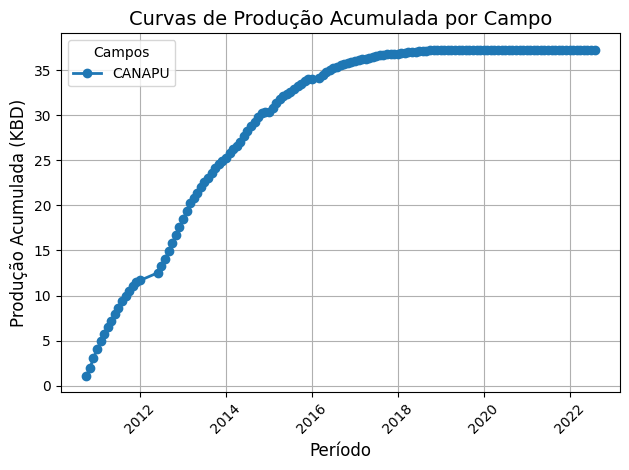

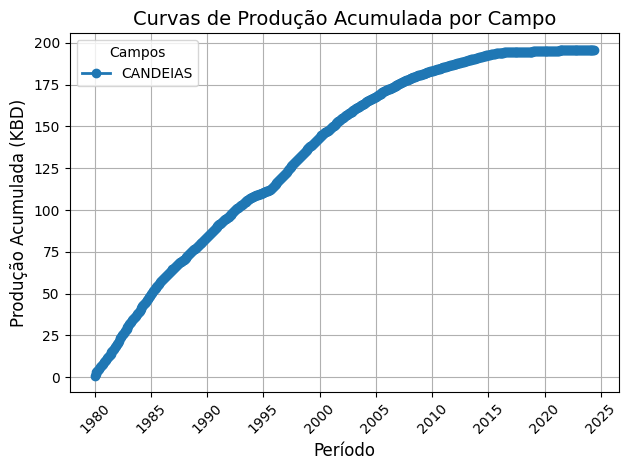

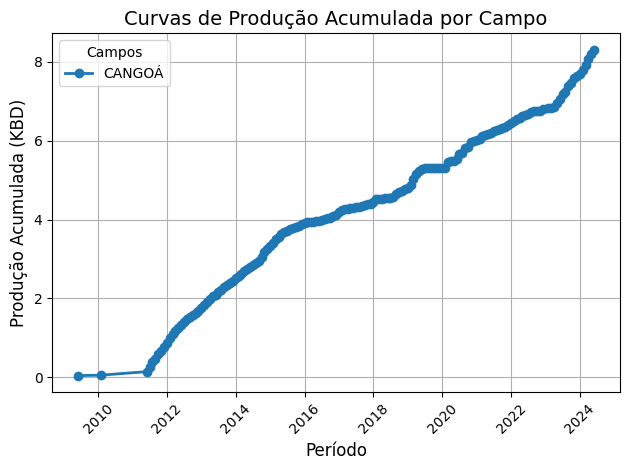

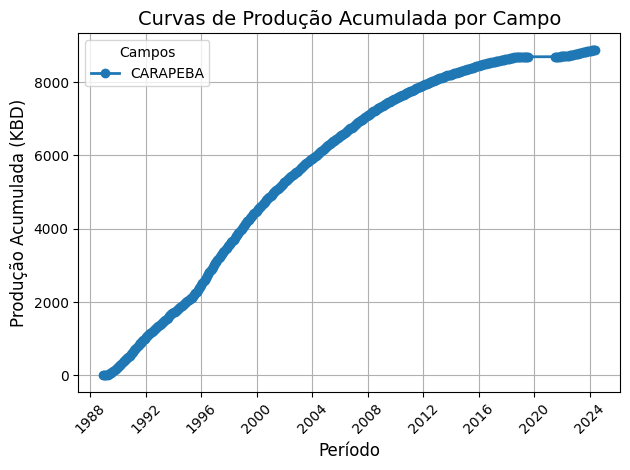

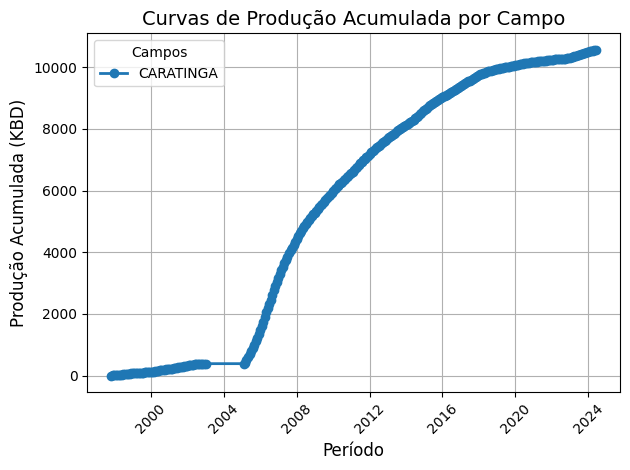

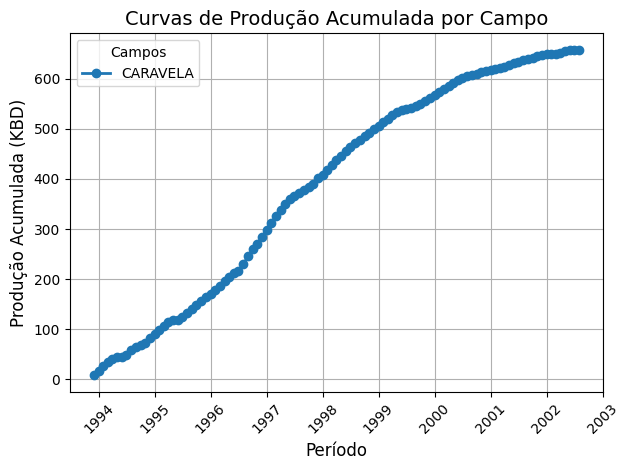

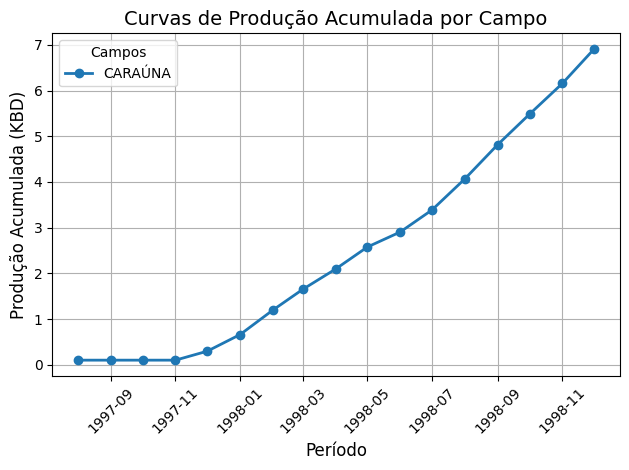

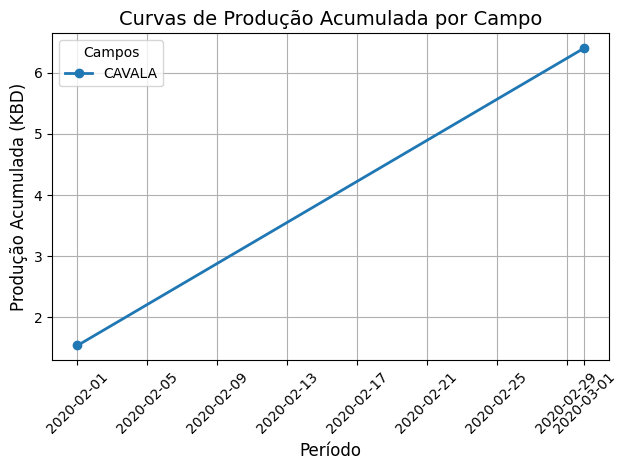

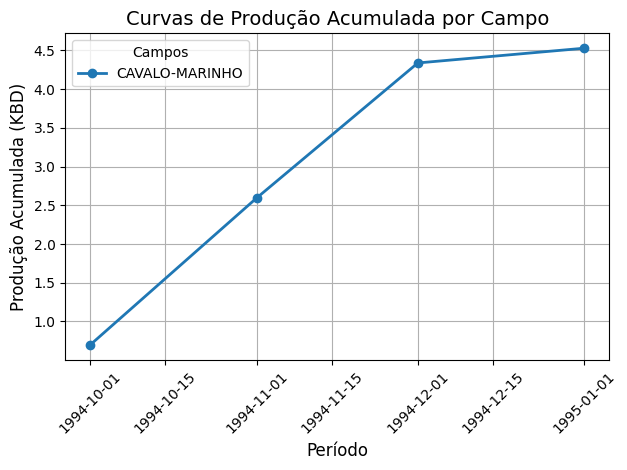

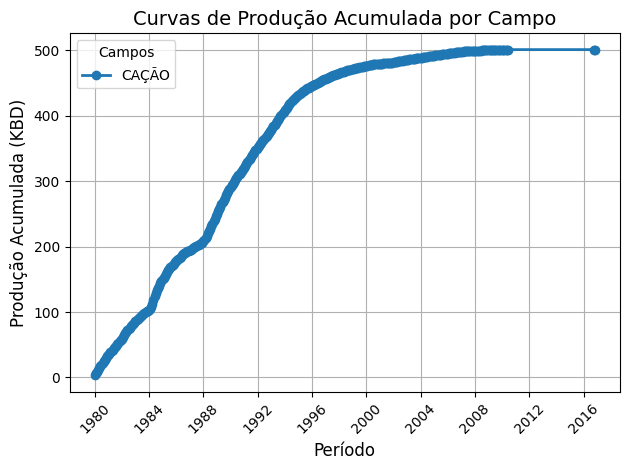

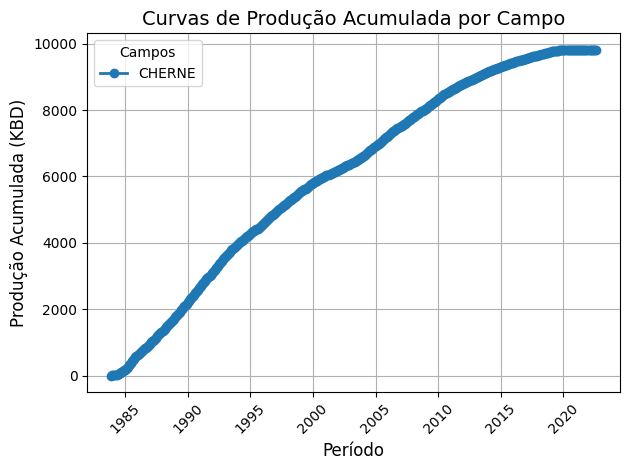

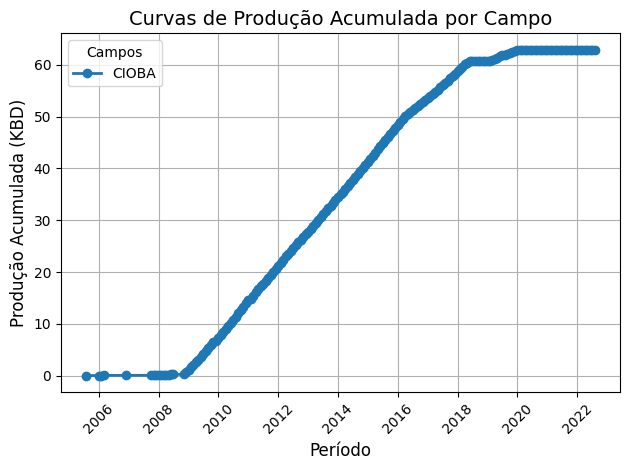

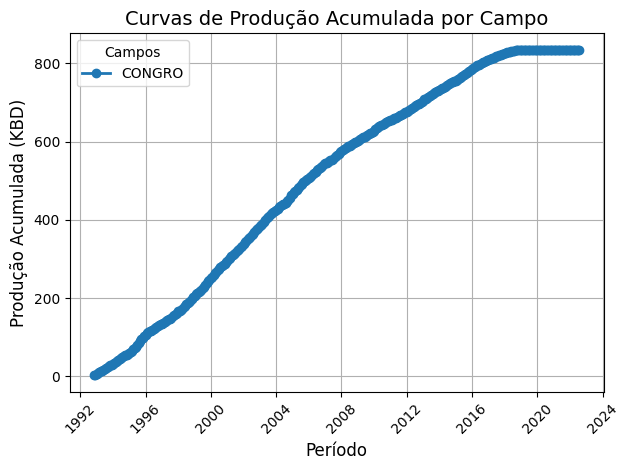

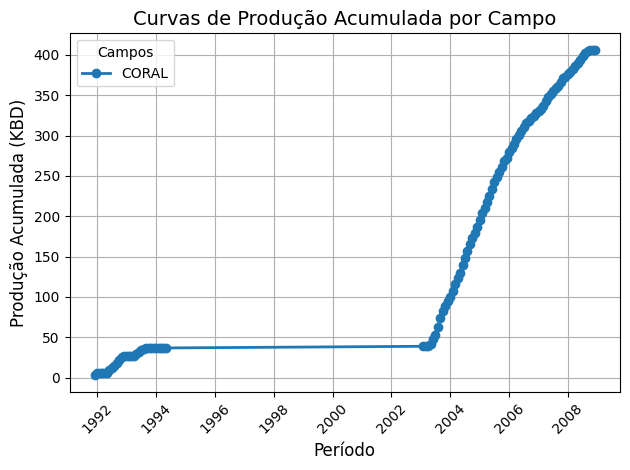

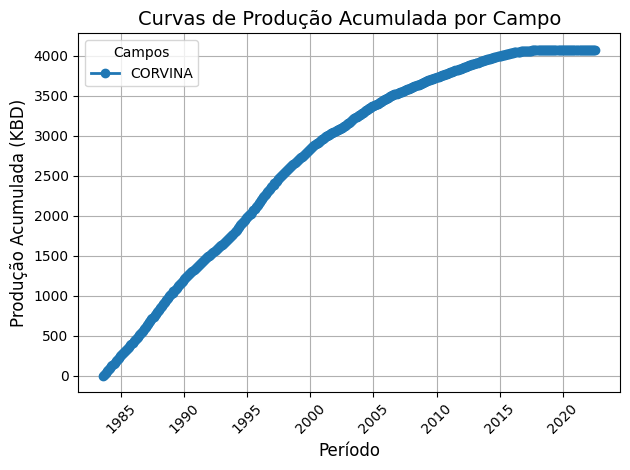

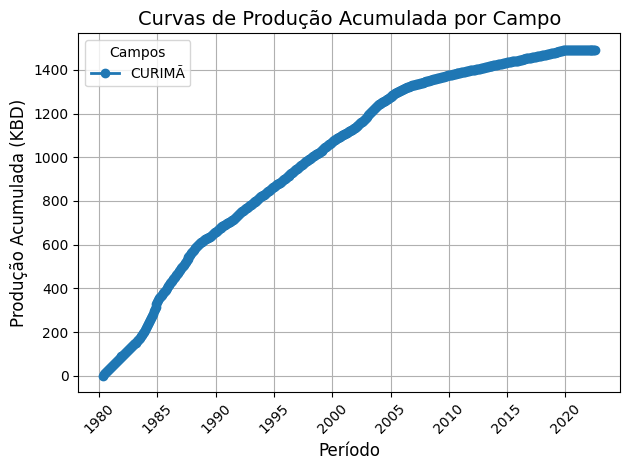

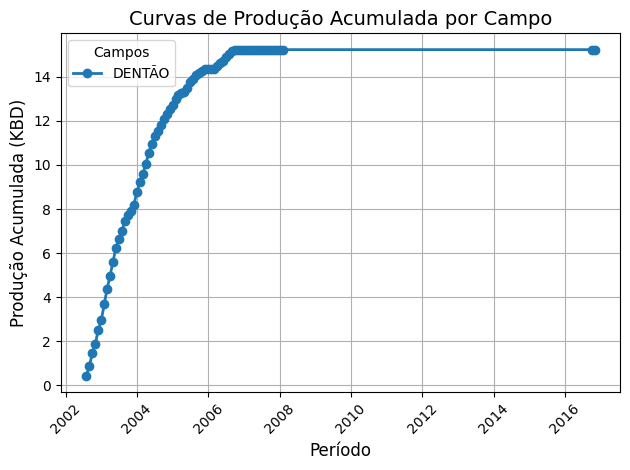

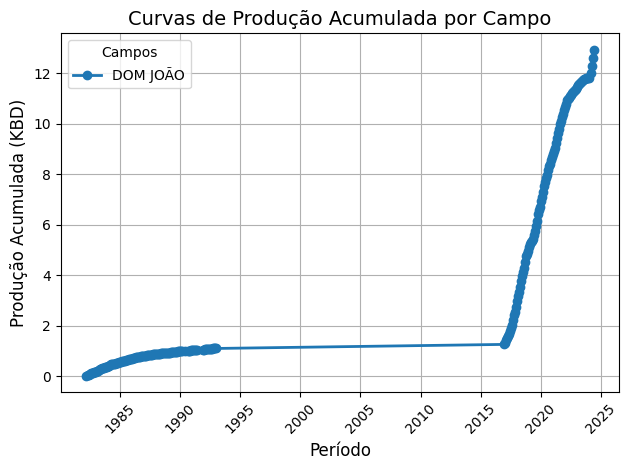

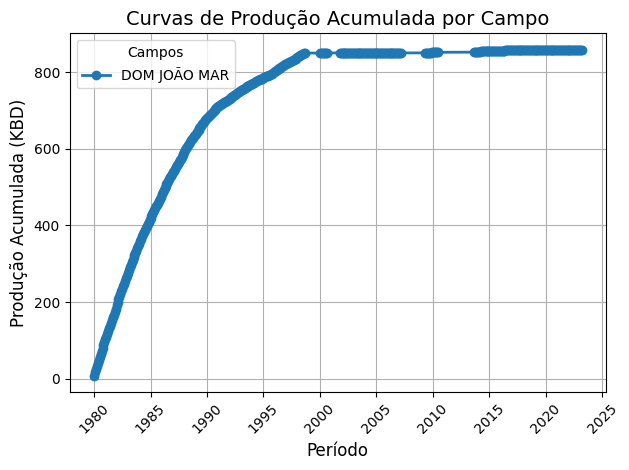

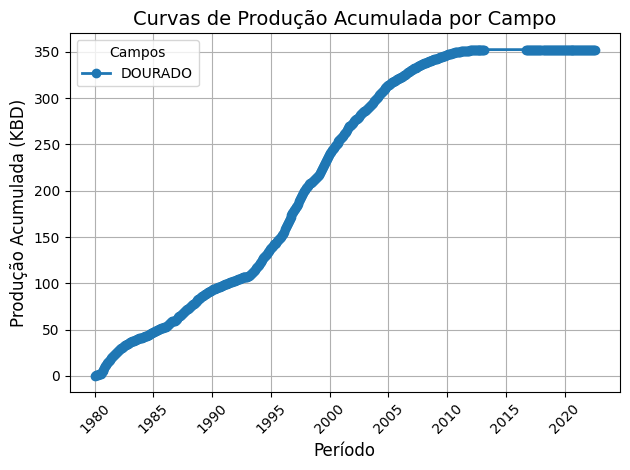

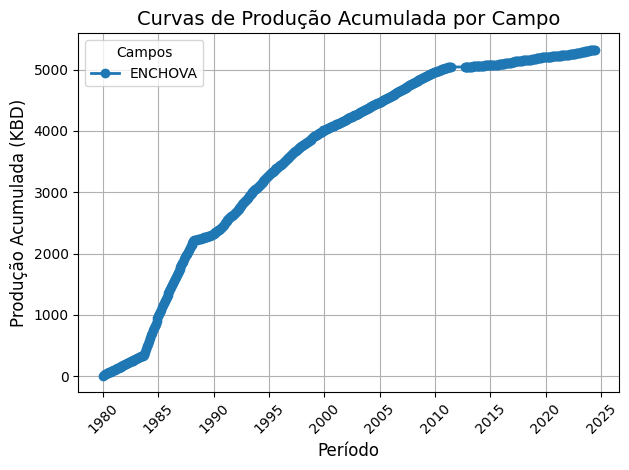

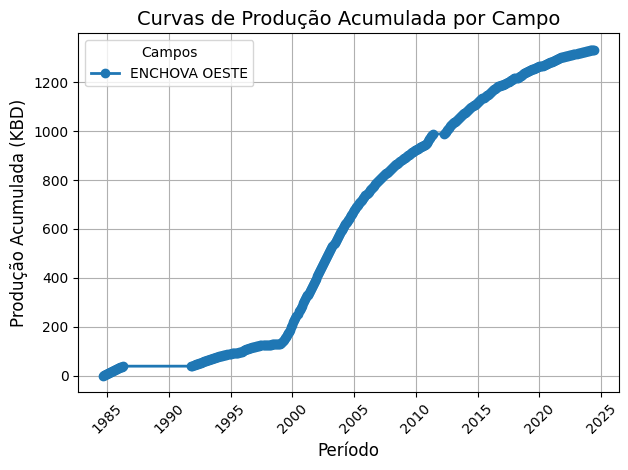

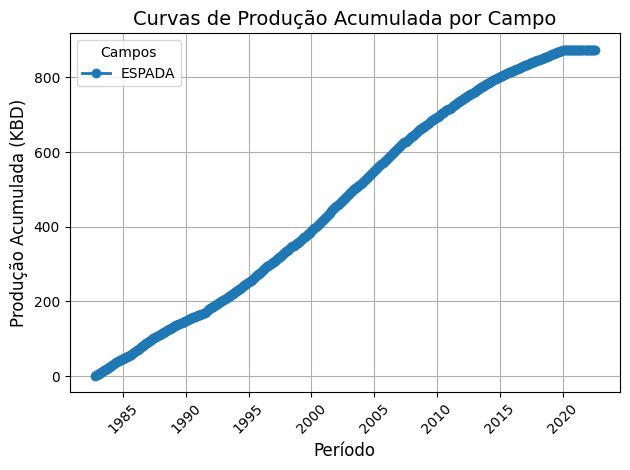

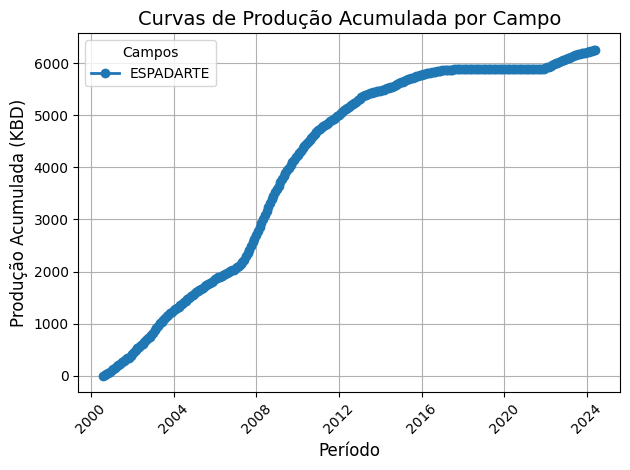

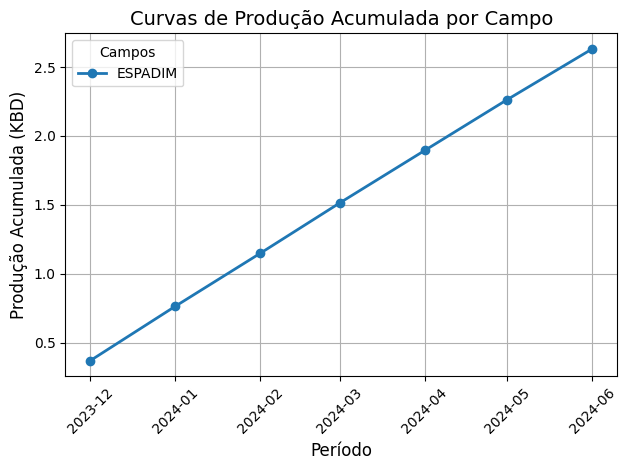

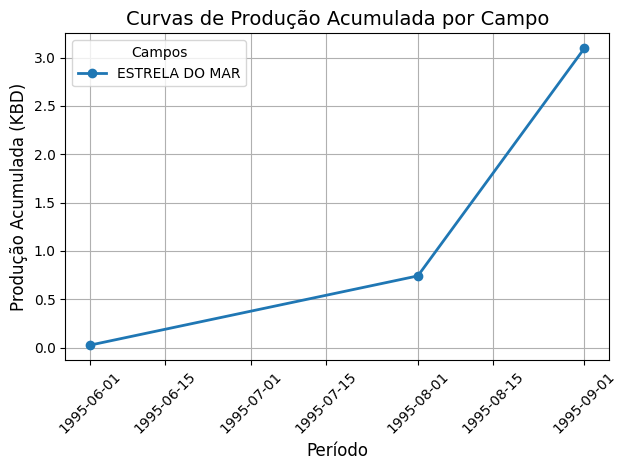

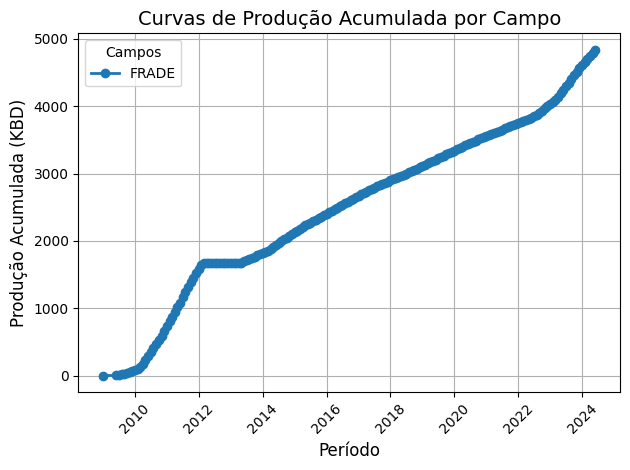

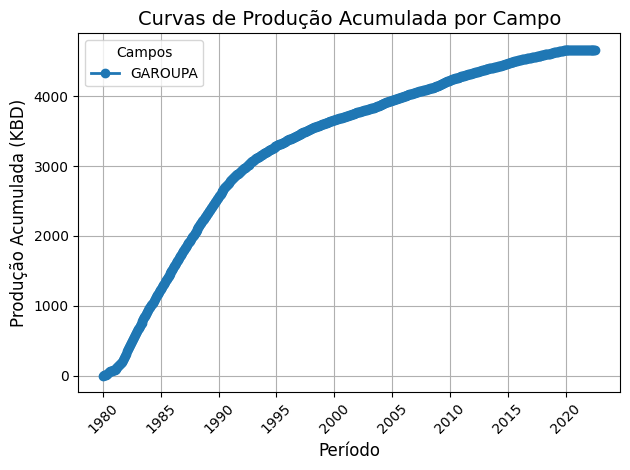

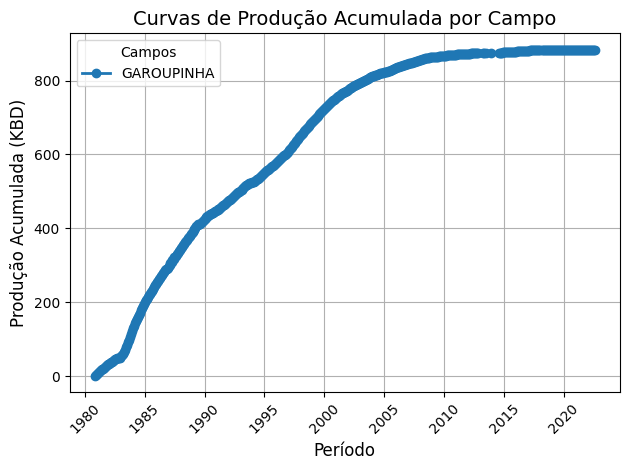

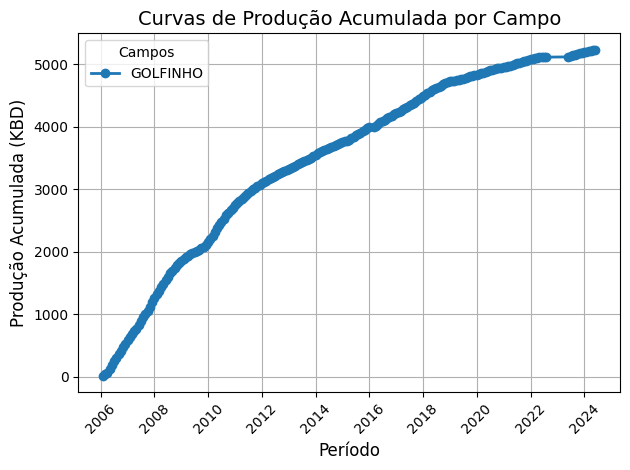

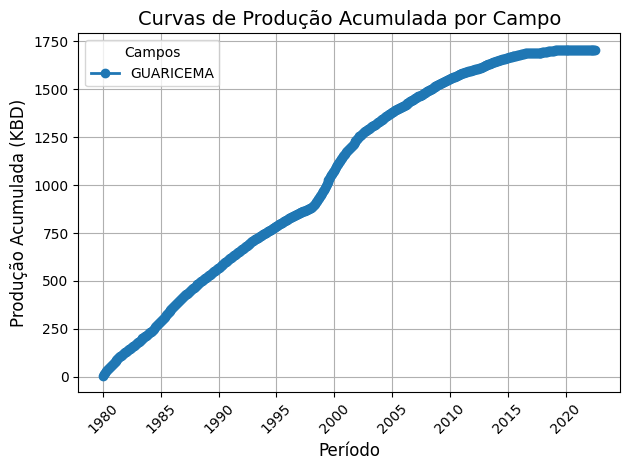

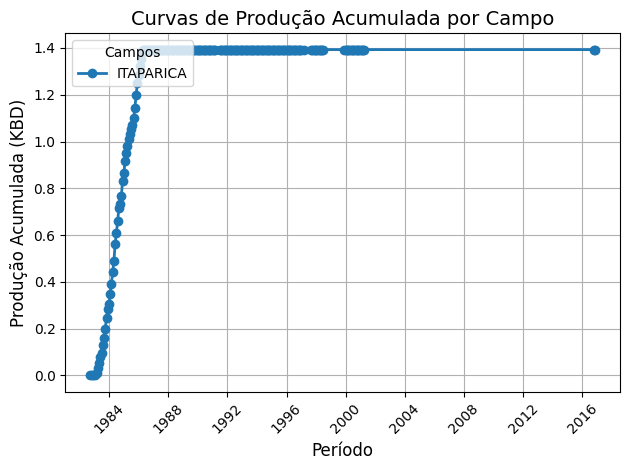

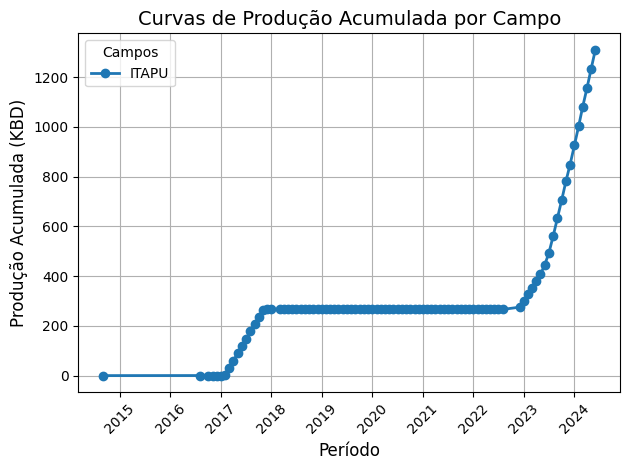

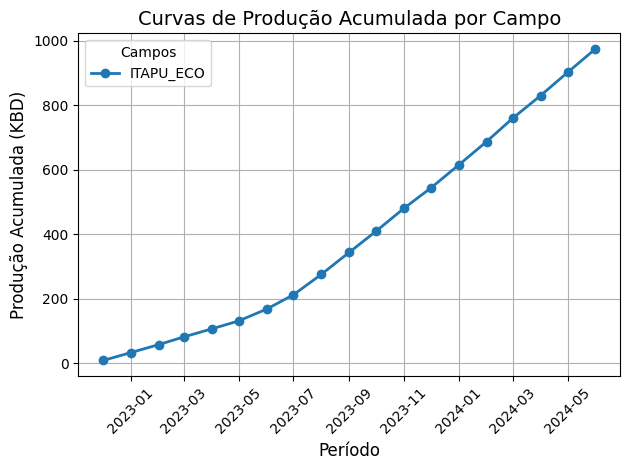

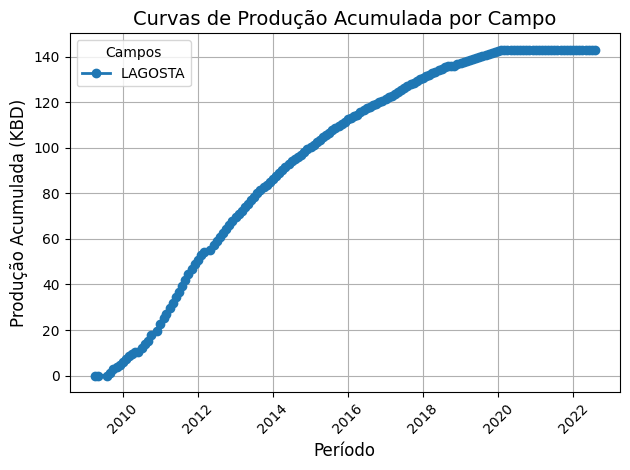

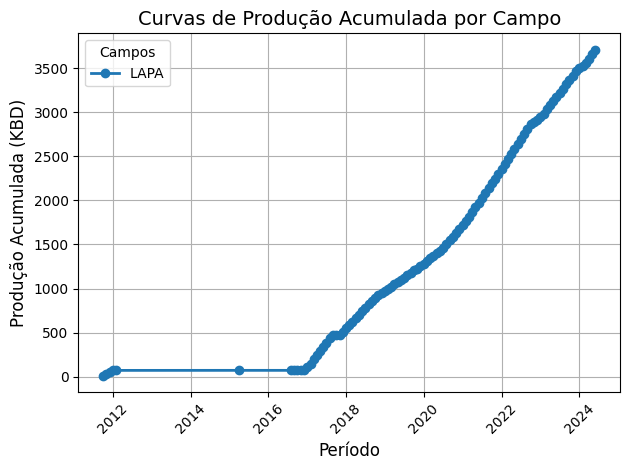

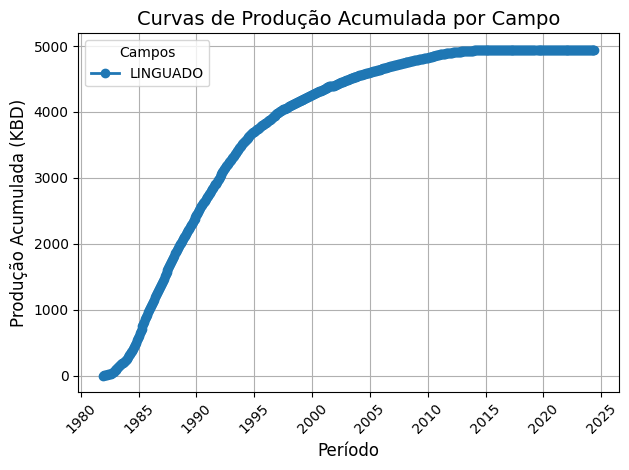

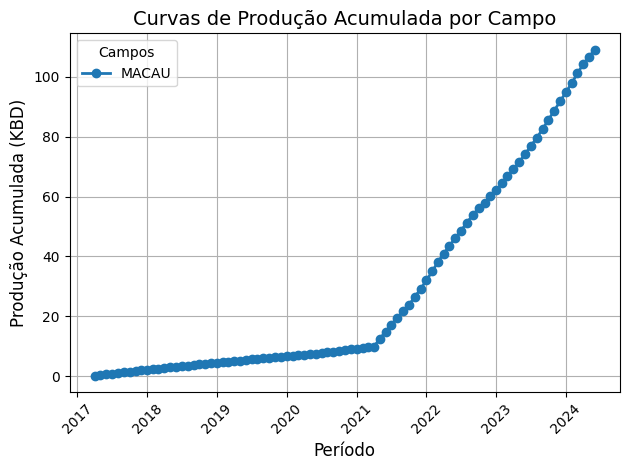

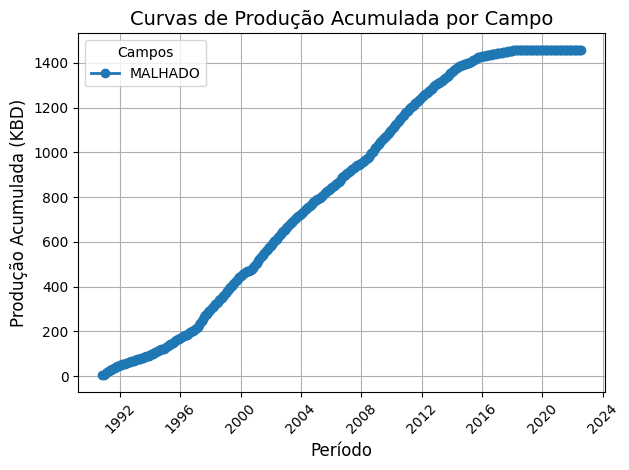

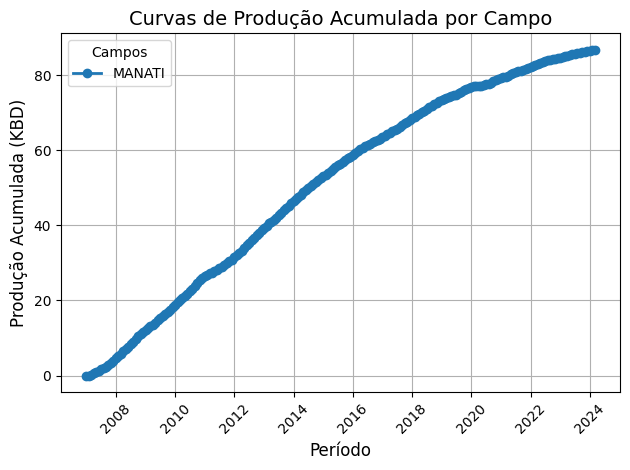

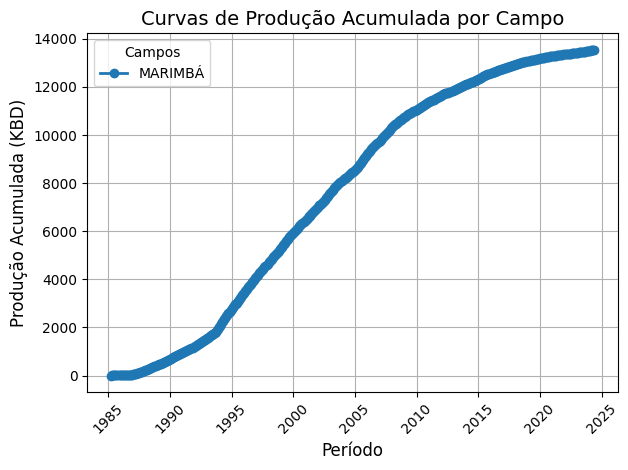

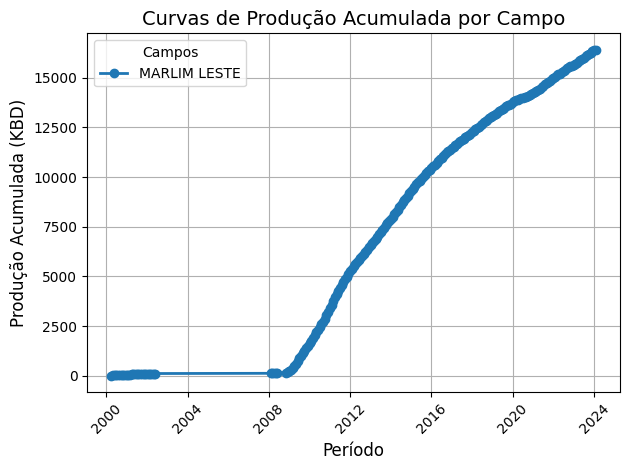

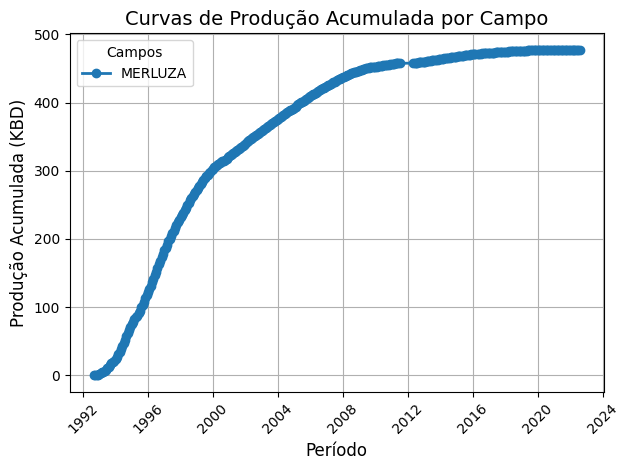

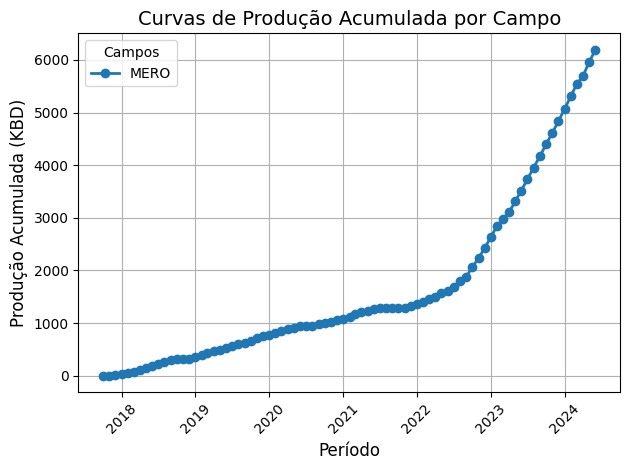

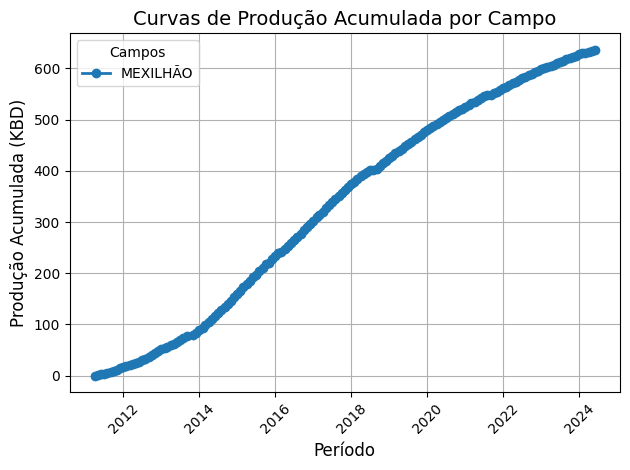

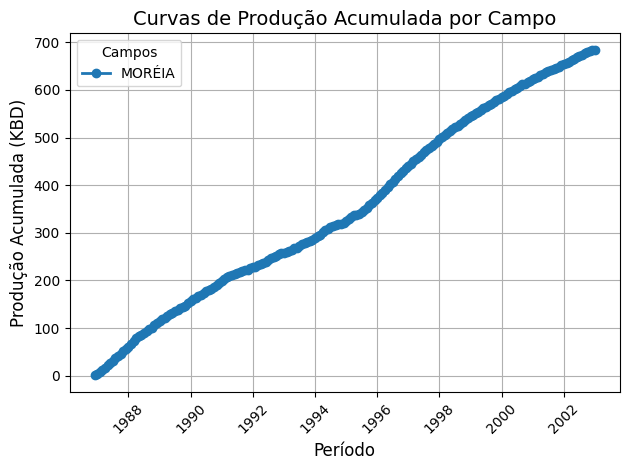

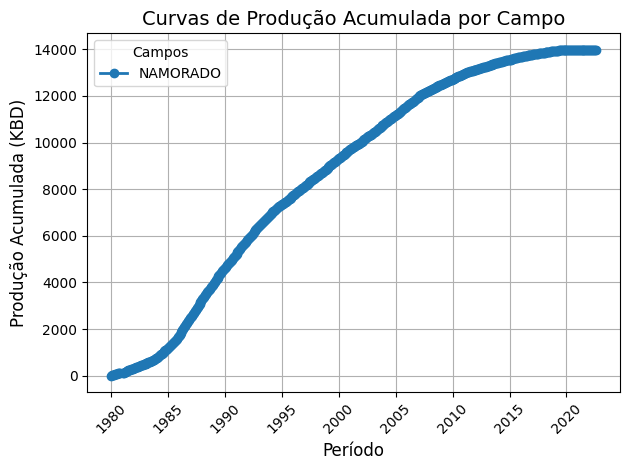

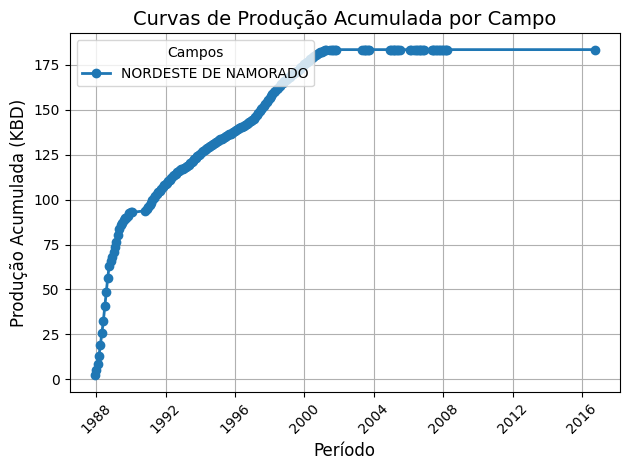

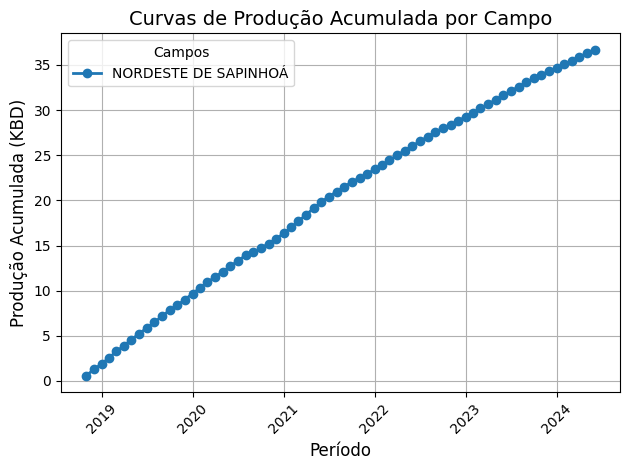

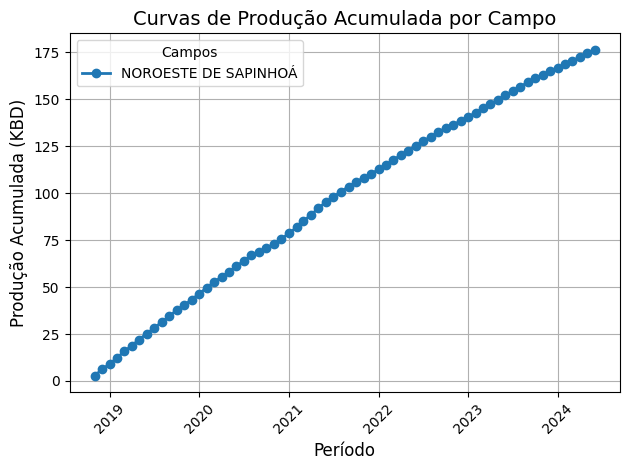

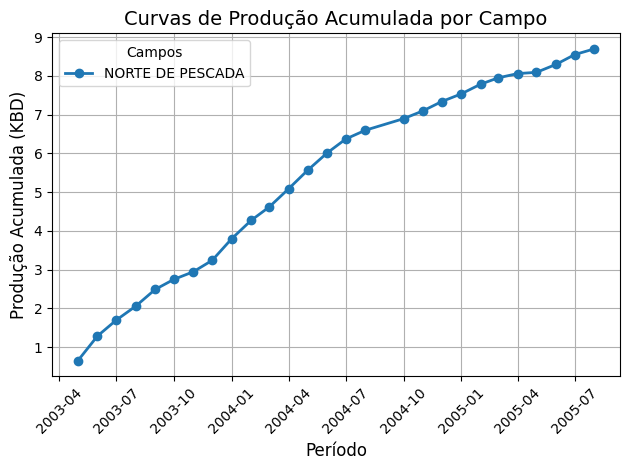

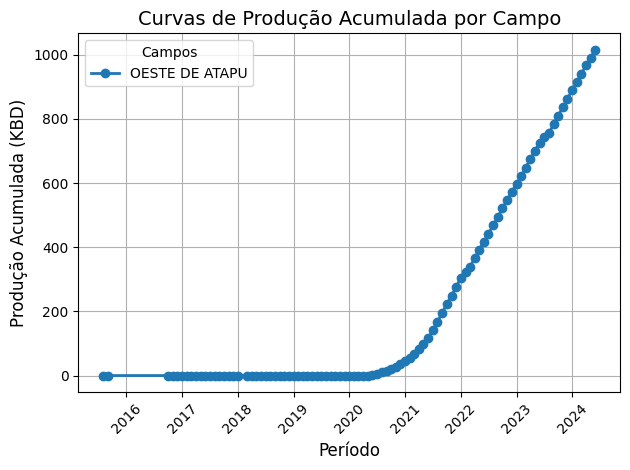

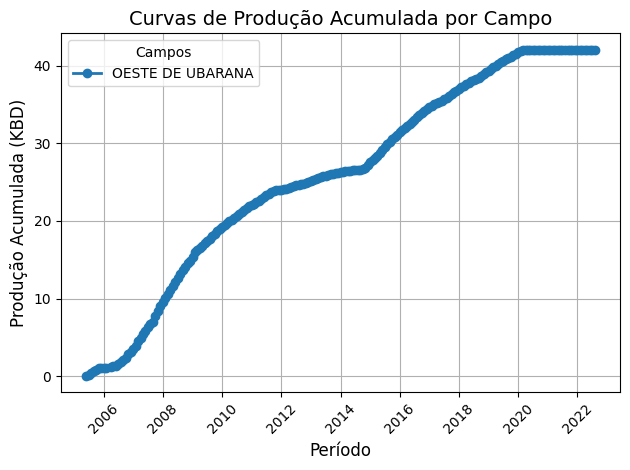

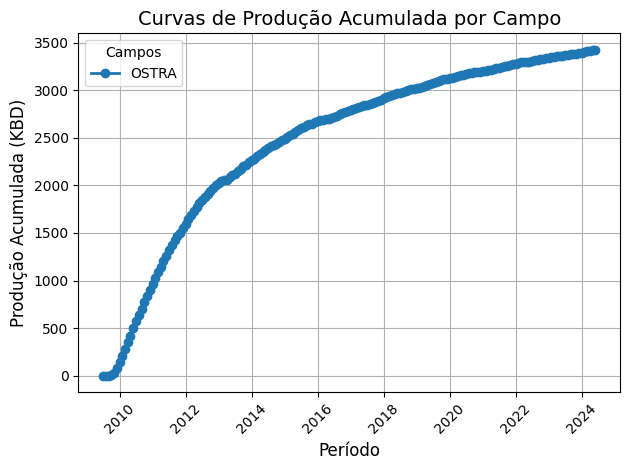

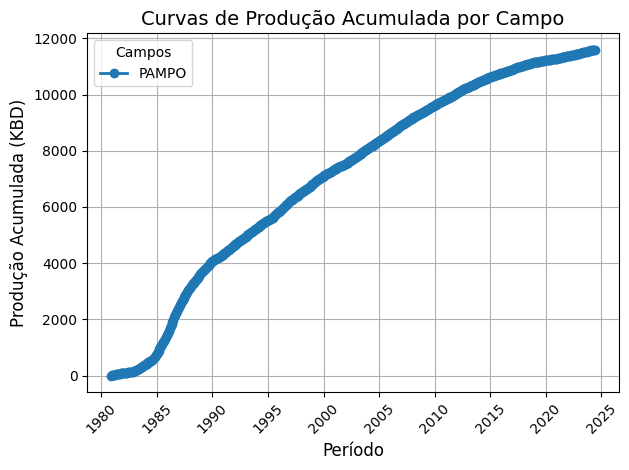

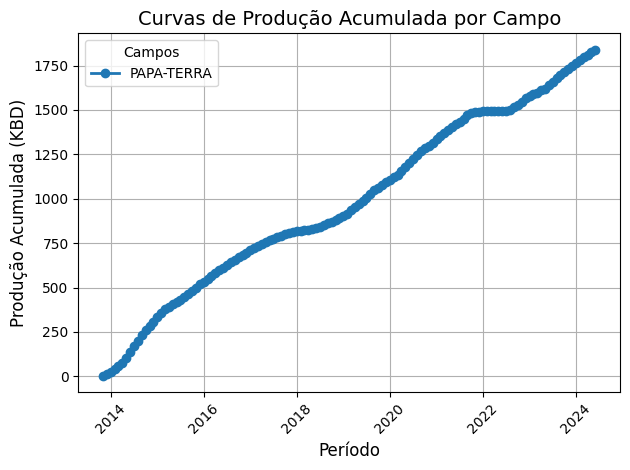

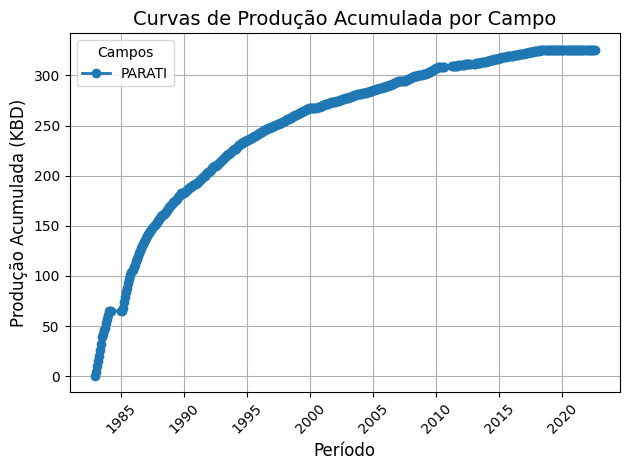

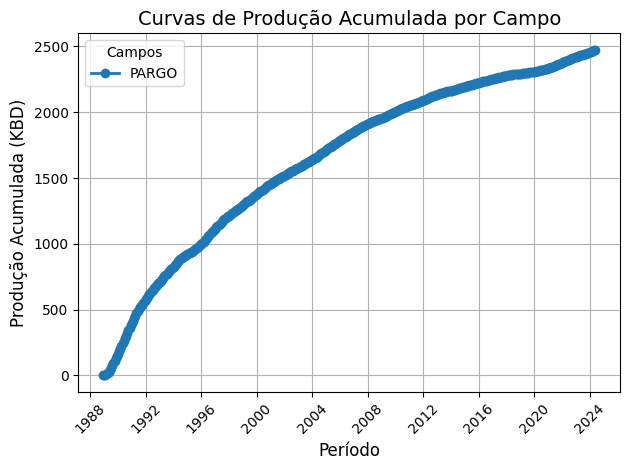

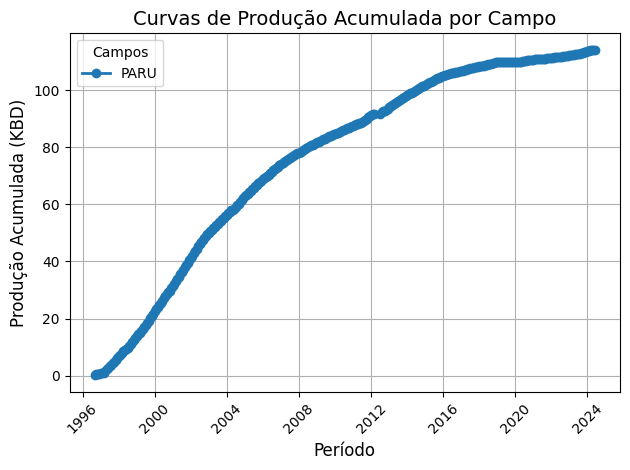

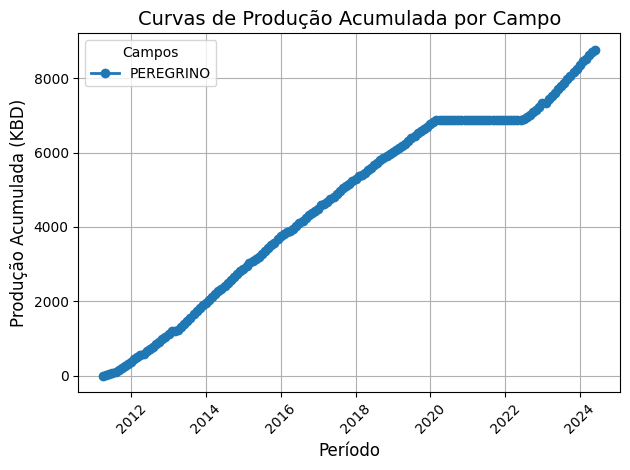

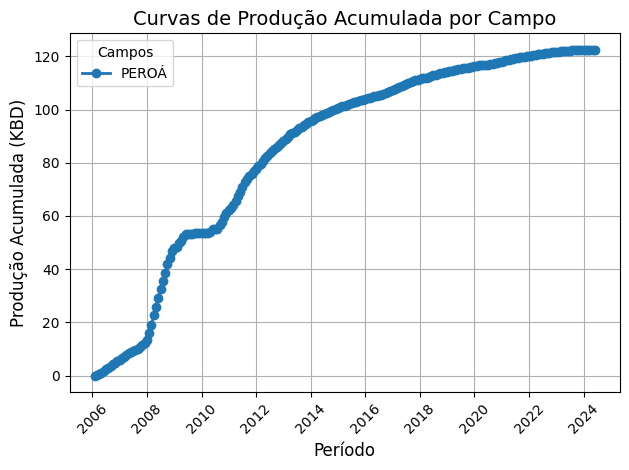

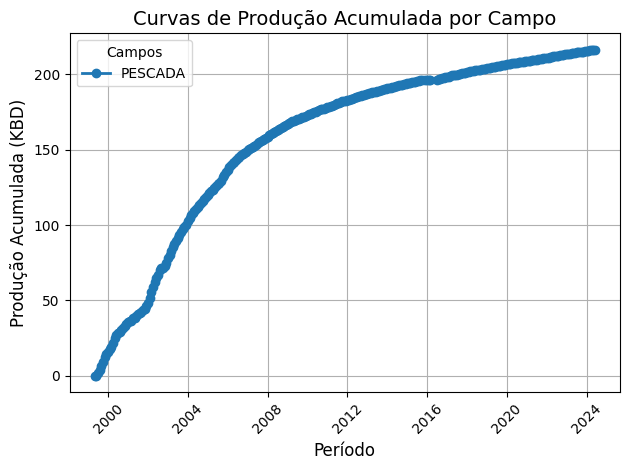

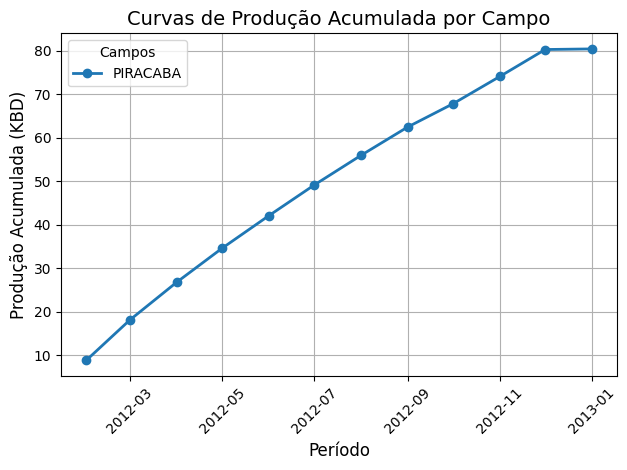

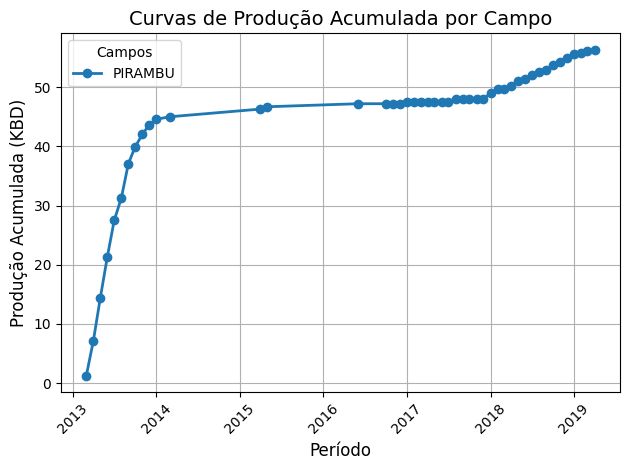

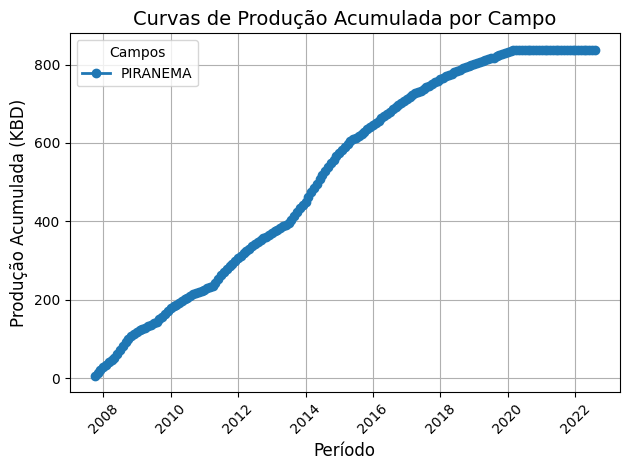

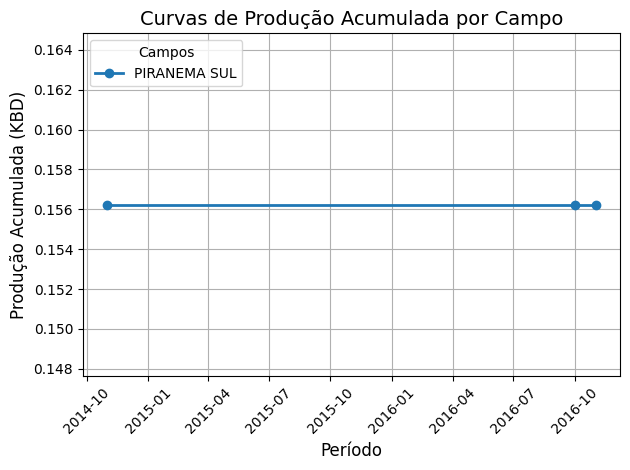

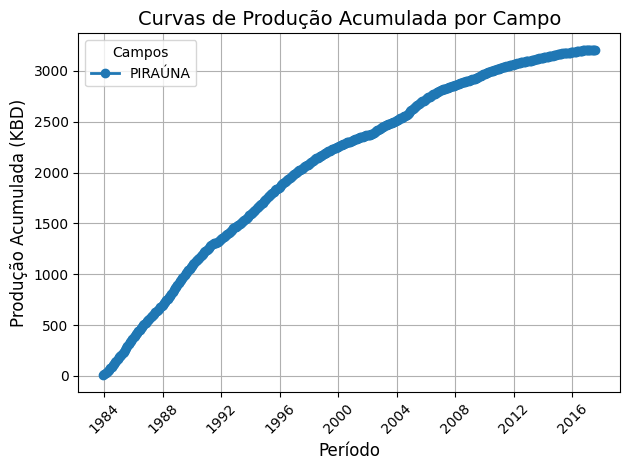

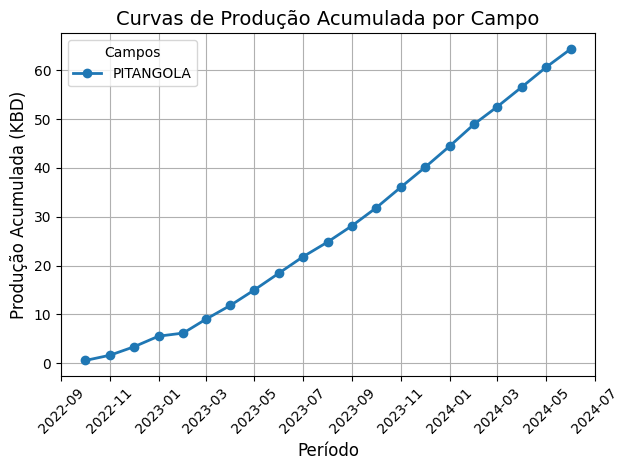

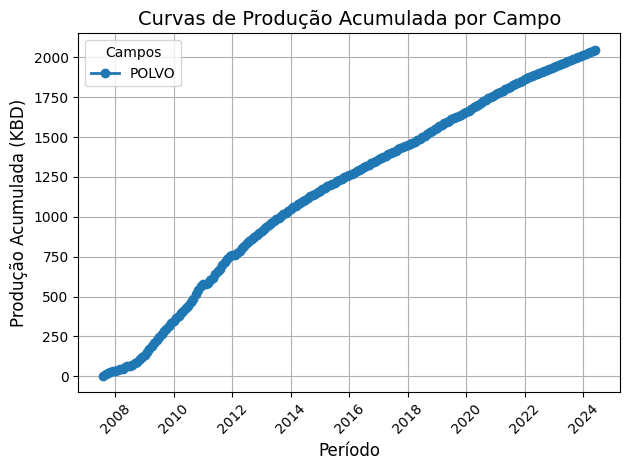

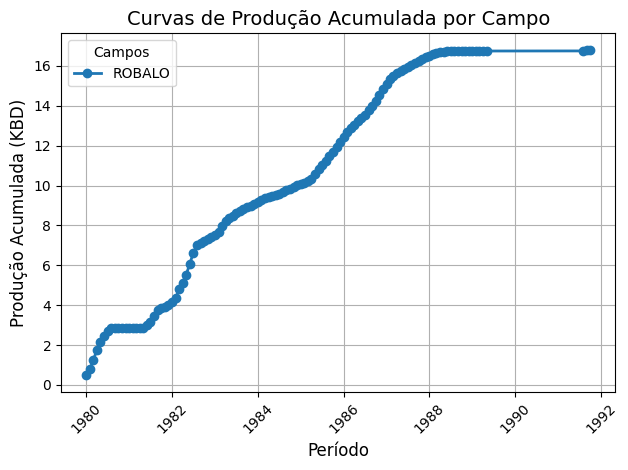

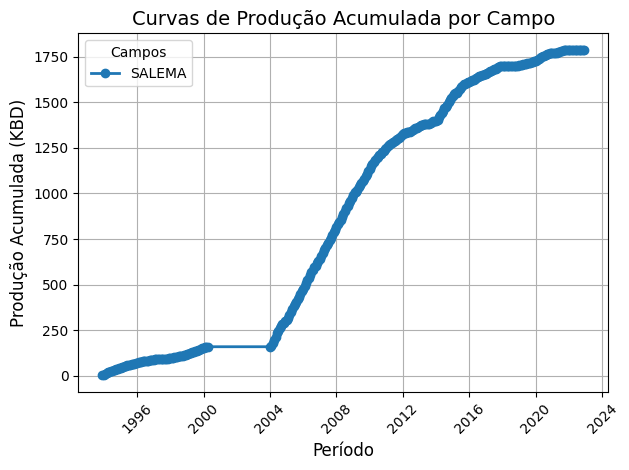

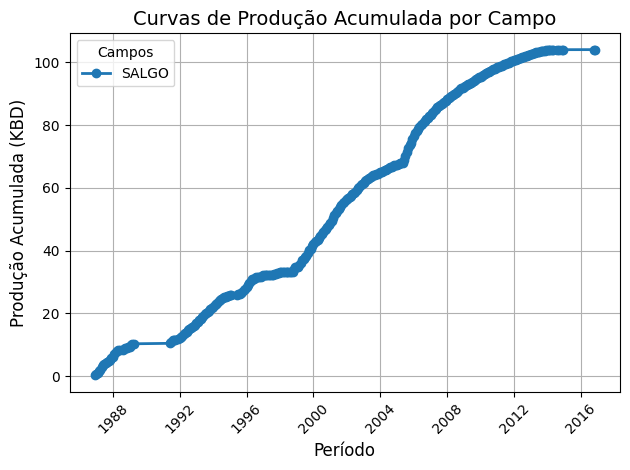

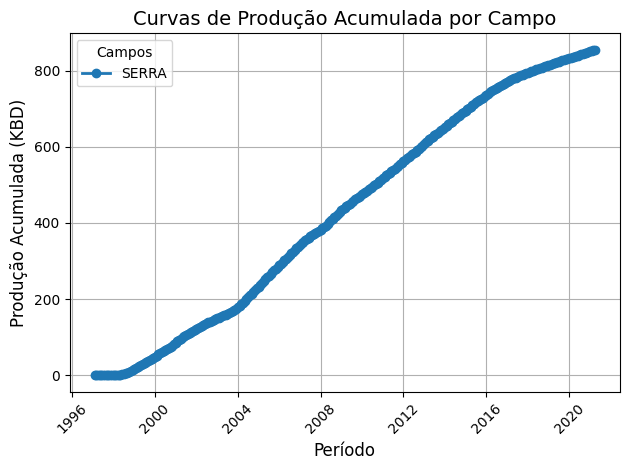

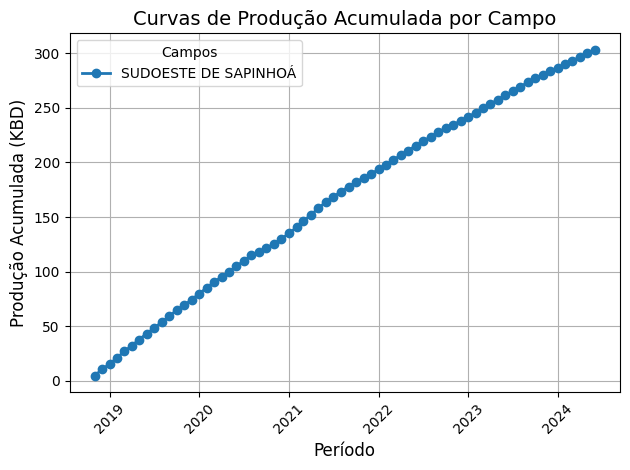

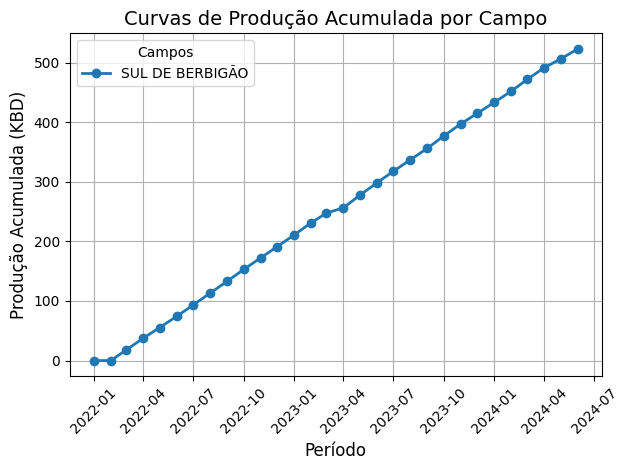

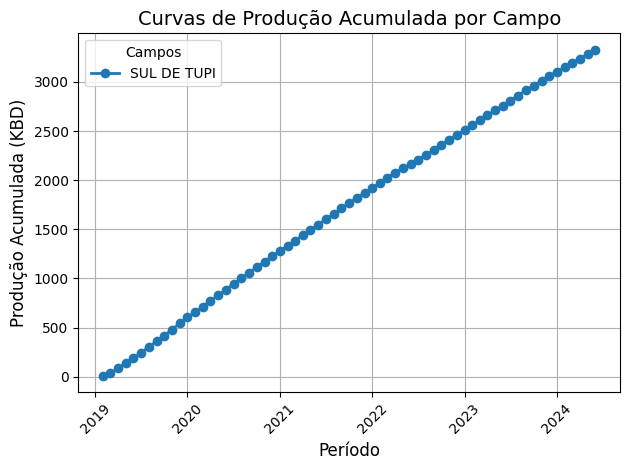

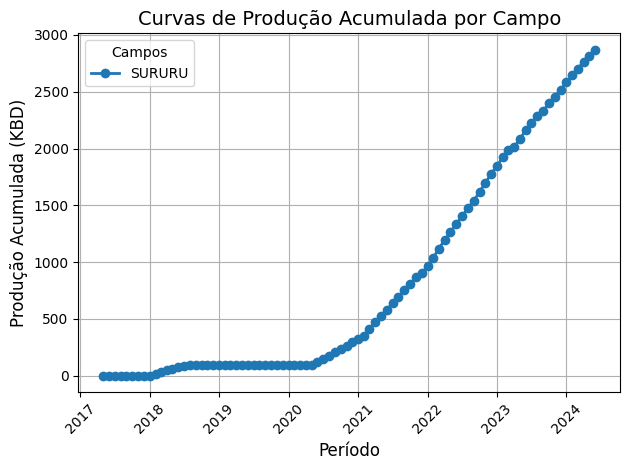

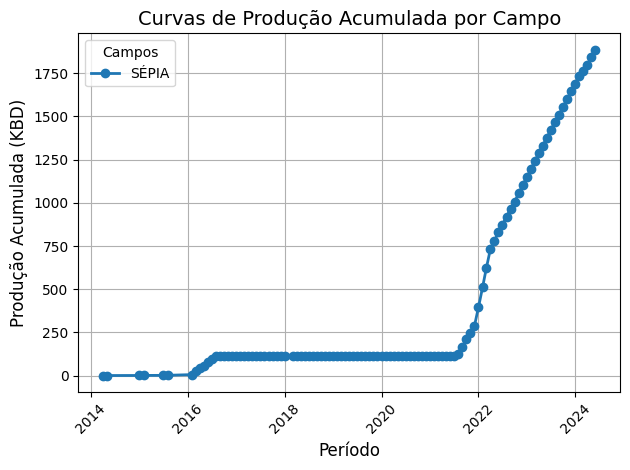

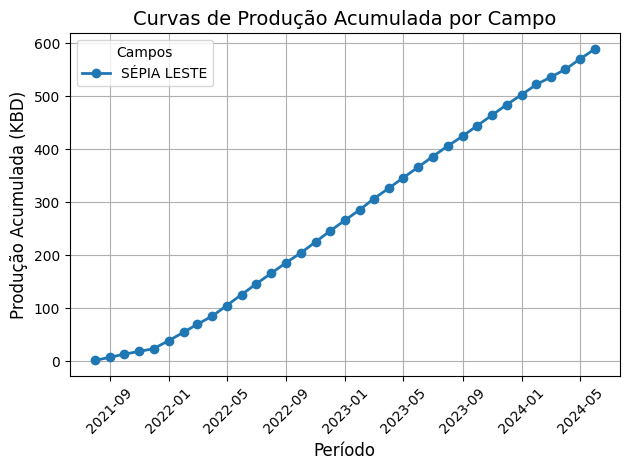

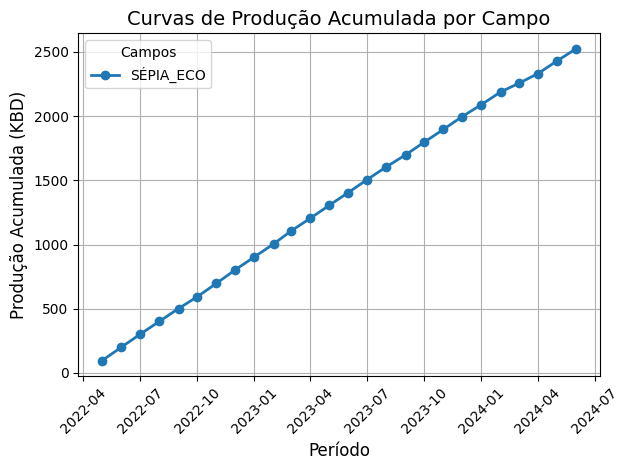

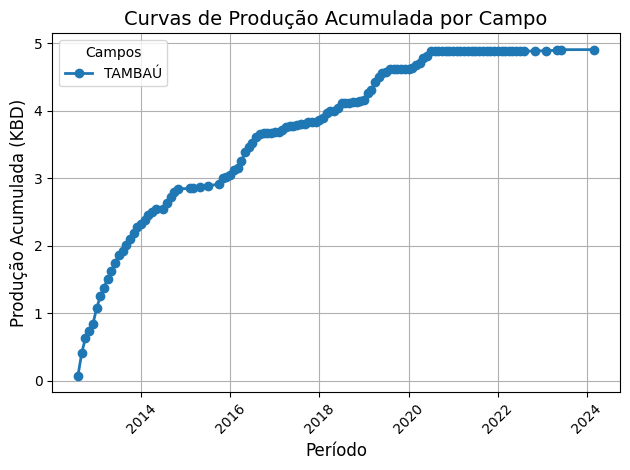

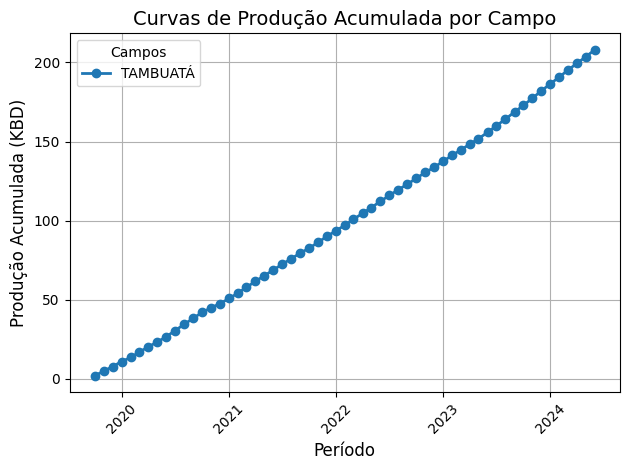

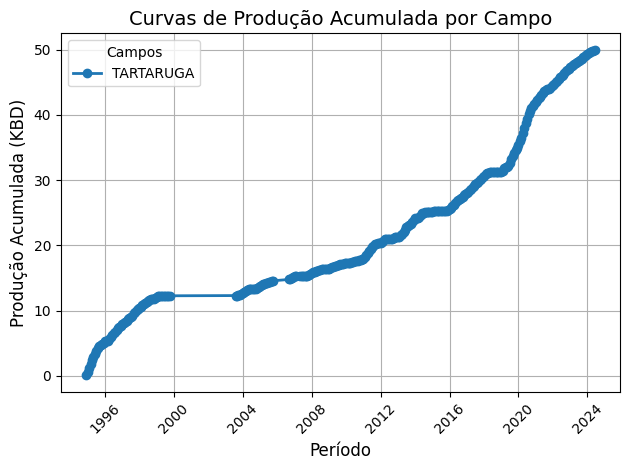

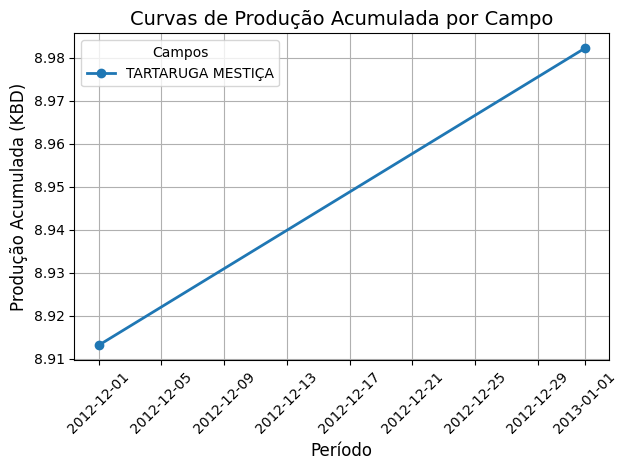

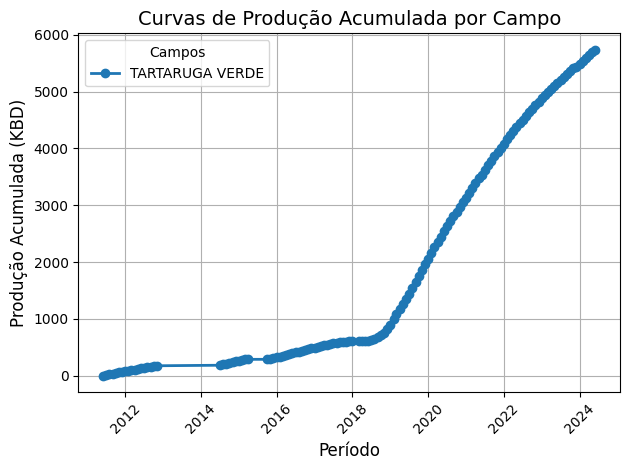

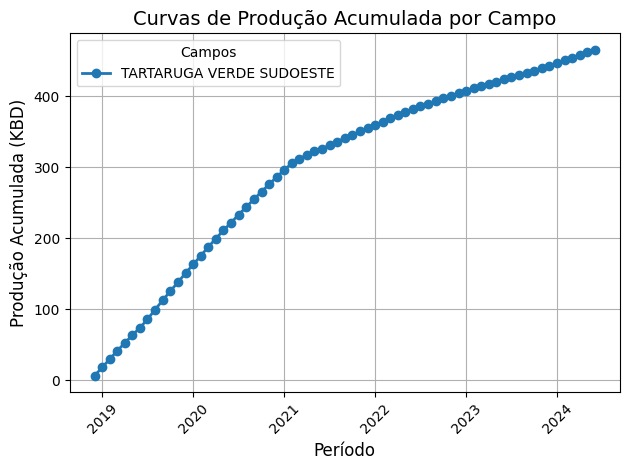

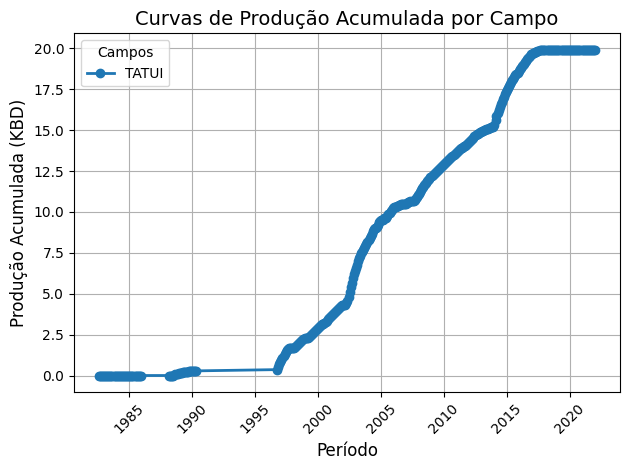

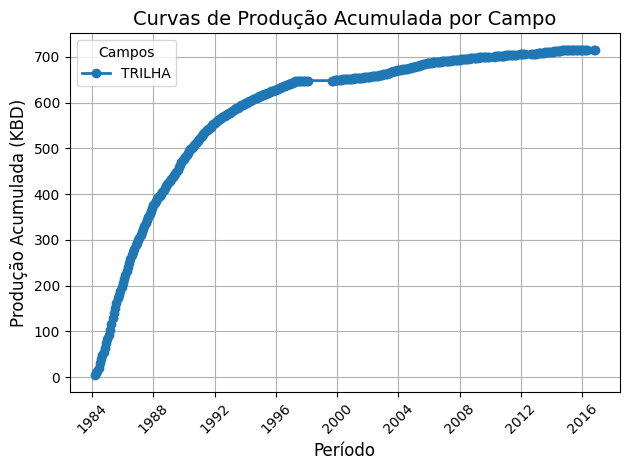

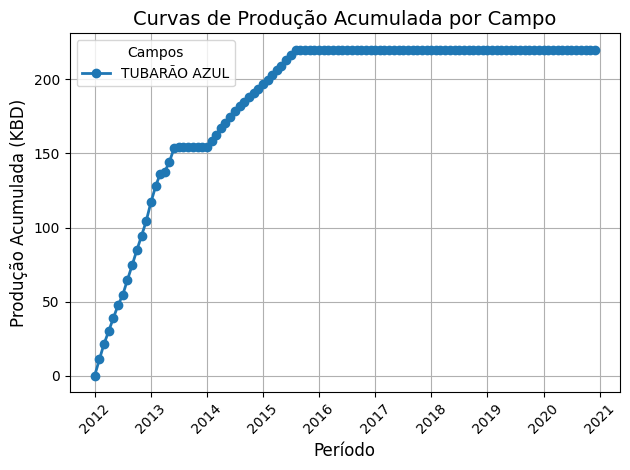

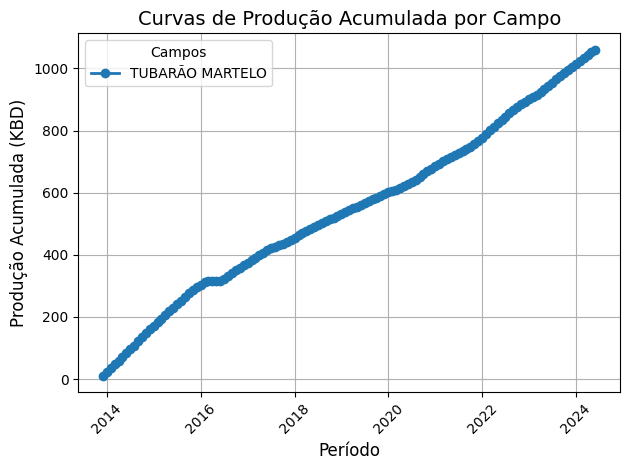

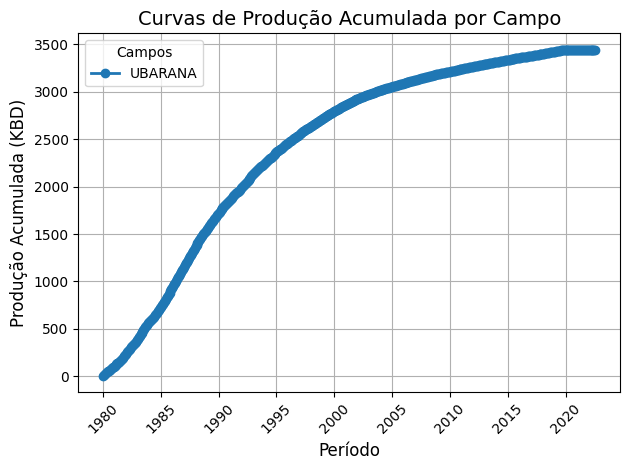

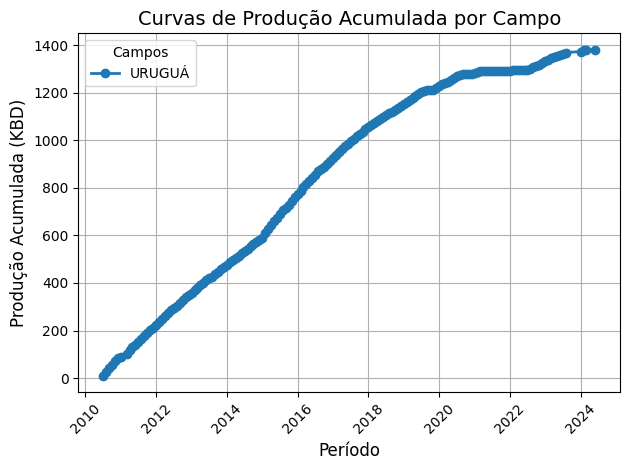

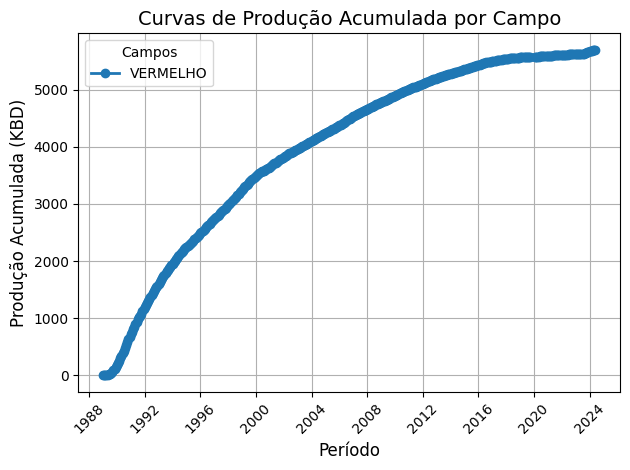

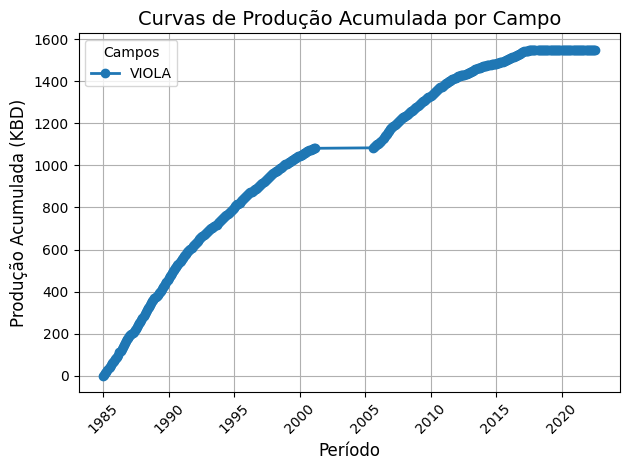

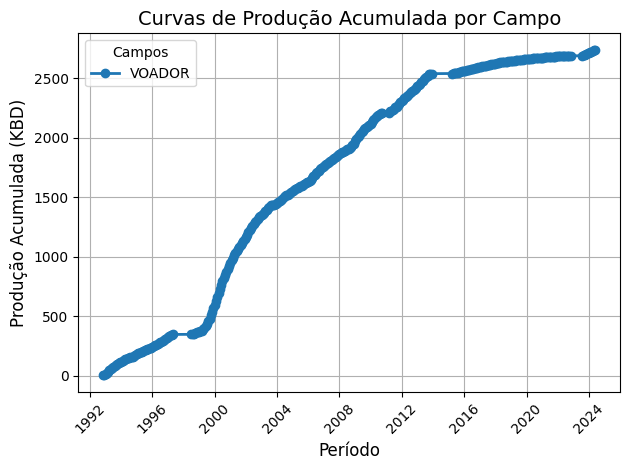

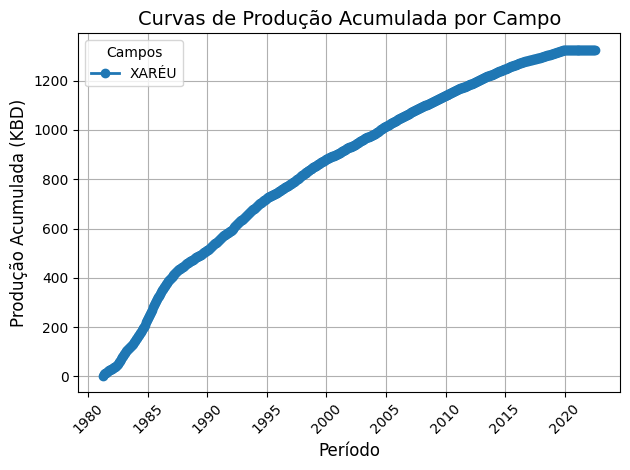

In [18]:
# Definir os campos para plotagem (substitua por campos específicos ou dinâmicos)
#campos_para_plotar = ['NAMORADO', 'ALBACORA', 'GAROUPA', 'ABALONE', 'BARRACUDA', 'BÚZIOS_ECO']  # Exemplo de campos
campos_para_plotar = ['ABALONE', 'AGULHA', 'ALBACORA LESTE', 'ANEQUIM', 'ARABAIANA',
 'ARATUM', 'ARGONAUTA', 'ATAPU', 'ATAPU_ECO', 'ATLANTA', 'ATUM', 'CAMARUPIM NORTE', 'CAMORIM', 'CANAPU',
 'CANDEIAS', 'CANGOÁ', 'CARAPEBA', 'CARATINGA', 'CARAVELA', 'CARAÚNA', 'CAVALA',
 'CAVALO-MARINHO', 'CAÇÃO', 'CHERNE', 'CIOBA', 'CONGRO', 'CORAL', 'CORVINA',
 'CURIMÃ', 'DENTÃO', 'DOM JOÃO', 'DOM JOÃO MAR', 'DOURADO', 'ENCHOVA',
 'ENCHOVA OESTE', 'ESPADA', 'ESPADARTE', 'ESPADIM', 'ESTRELA DO MAR', 'FRADE',
 'GAROUPA', 'GAROUPINHA', 'GOLFINHO', 'GUARICEMA', 'ITAPARICA', 'ITAPU',
 'ITAPU_ECO', 'LAGOSTA', 'LAPA', 'LINGUADO', 'MACAU', 'MALHADO',
 'MANATI', 'MARIMBÁ', 'MARLIM LESTE', 'MERLUZA', 'MERO',
 'MEXILHÃO', 'MORÉIA', 'NAMORADO', 'NORDESTE DE NAMORADO',
 'NORDESTE DE SAPINHOÁ', 'NOROESTE DE SAPINHOÁ', 'NORTE DE PESCADA',
 'OESTE DE ATAPU', 'OESTE DE UBARANA', 'OSTRA', 'PAMPO', 'PAPA-TERRA', 'PARATI',
 'PARGO', 'PARU', 'PEREGRINO', 'PEROÁ',
 'PESCADA', 'PIRACABA', 'PIRAMBU', 'PIRANEMA', 'PIRANEMA SUL', 'PIRAÚNA',
 'PITANGOLA', 'POLVO', 'ROBALO', 'SALEMA', 'SALGO', 'SERRA', 'SUDOESTE DE SAPINHOÁ', 'SUL DE BERBIGÃO', 'SUL DE TUPI', 'SURURU',
 'SÉPIA', 'SÉPIA LESTE', 'SÉPIA_ECO', 'TAMBAÚ', 'TAMBUATÁ', 'TARTARUGA',
 'TARTARUGA MESTIÇA', 'TARTARUGA VERDE', 'TARTARUGA VERDE SUDOESTE', 'TATUI',
 'TRILHA', 'TUBARÃO AZUL', 'TUBARÃO MARTELO', 'UBARANA', 'URUGUÁ',
 'VERMELHO', 'VIOLA', 'VOADOR', 'XARÉU']


# Criar um gráfico para cada campo
plt.figure(figsize=(10, 6))

# Plotar a produção acumulada de cada campo na lista
for campo in campos_para_plotar:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['producao_acumulada'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção Acumulada por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção Acumulada (KBD)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### MACHINE LEARNING

In [ ]:
display(df_prod)

periodo   nome_poco_anp   oleo_kbd  condensado_kbd  petroleo_kbd  \
0      2011-01-01   3-RJS-159-RJS   0.293000             0.0      0.293000   
1      2011-01-01    7-PM-17D-RJS   0.196663             0.0      0.196663   
2      2011-01-01  6-BRSA-806-RJS  13.362645             0.0     13.362645   
3      2011-01-01  4-RJS-265A-RJS   0.241780             0.0      0.241780   
4      2011-01-01  1-BRSA-594-SPS  17.756235             0.0     17.756235   
...           ...             ...        ...             ...           ...   
476707 2024-06-01    7-OST-6H-ESS   0.000000             0.0      0.000000   
476708 2024-06-01    7-OST-7H-ESS   0.000000             0.0      0.000000   
476709 2024-06-01    7-OST-3H-ESS   2.115484             0.0      2.115484   
476710 2024-06-01    7-OST-1H-ESS   1.685027             0.0      1.685027   
476711 2024-06-01    7-OST-2H-ESS   0.615693             0.0      0.615693   

        gas_natural_mmscf_assoc  gas_natural_mmscf_nassoc  \
0                      0.287652                       0.0   
1                      0.108893                       0.0   
2                      7.112691                       0.0   
3                      0.177410                       0.0   
4                     19.470869                       0.0   
...                         ...                       ...   
476707                 0.000000                       0.0   
476708                 0.000000                       0.0   
476709                 0.428597                       0.0   
476710                 0.535491                       0.0   
476711                 0.205330                       0.0   

        gas_natural_mmscf_total   agua_kbd          estado   bacia      campo  \
0                      0.287652   0.125568  Rio de Janeiro  Campos      PAMPO   
1                      0.108893   0.012550  Rio de Janeiro  Campos      PAMPO   
2                      7.112691   0.033568  Rio de Janeiro  Campos  CARATINGA   
3                      0.177410   0.004931  Rio de Janeiro  Campos     TRILHA   
4                     19.470869   0.000000       São Paulo  Santos   SAPINHOÁ   
...                         ...        ...             ...     ...        ...   
476707                 0.000000   0.000000  Espírito Santo  Campos      OSTRA   
476708                 0.000000   0.000000  Espírito Santo  Campos      OSTRA   
476709                 0.428597  12.502358  Espírito Santo  Campos      OSTRA   
476710                 0.535491  14.169057  Espírito Santo  Campos      OSTRA   
476711                 0.205330   3.587105  Espírito Santo  Campos      OSTRA   

        tempo_producao_hspormes   ano  mes  dias_no_mes  producao_total_mes  \
0                             0  2011    1           31            9.083000   
1                             0  2011    1           31            6.096562   
2                             0  2011    1           31          414.241980   
3                             0  2011    1           31            7.495177   
4                             0  2011    1           31          550.443288   
...                         ...   ...  ...          ...                 ...   
476707                        0  2024    6           30            0.000000   
476708                        0  2024    6           30            0.000000   
476709                      554  2024    6           30           63.464517   
476710                      556  2024    6           30           50.550819   
476711                      220  2024    6           30           18.470787   

        producao_acumulada  
0                 9.083000  
1                 6.096562  
2               414.241980  
3                 7.495177  
4               550.443288  
...                    ...  
476707        17656.181326  
476708        10322.332878  
476709        21717.816577  
476710        16375.090354  
476711        19248.500270  

[449640 rows x 18 columns]